# Load modules

In [120]:
import pandas as pd
# import pyupset as pyu
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pyupset as pyu
import matplotlib
# from matplotlib_venn import venn2
# from matplotlib import gridspec
cas_dict = np.load('figure_data/cas_abbrev_dict.npy').item()
cas_dict['all'] = 'all'
%matplotlib inline

### hg19 analysis overview

Started with list of 25,867 genes annotated by RefSeq. Excluded if no coding exons or no individuals have enough hets, so 14,795 evaluated for targetability.

#### hg19 + 5 kb overview
25,867 genes annotated, 14,864 evaluated.

### hg38 analysis overview

Started with 36,670 genes annotated by RefSeq. 14,586 evaluated.

#### hg38 + 5 kb overview

36,670 genes annotated, still finishing up 6 genes for 5 kb.

# Comparison of stock sgRNA libraries with personalized sgRNAs from WTC

* unable to evaluate a whole gene for all allele-specific cut sites
* genome-wide provides 3-6 sgRNAs per gene
* ~1 bp / 1000 is a variant in average person [cite](https://www.ncbi.nlm.nih.gov/books/NBK20363/)
* if you designed all guides in the genome simply based on hg19, how many would contain a variant and thus be less effective?

36 variants in BEST1, mostly homozygous.

In [2]:
# compare density of sgRNA across BEST1 (homozygous guides) personalized vs. non:

ref_guides = pd.read_csv('figure_data/ref_vs_personalized_guides_wtc_best1/ref_hom_sgRNAs_hg19_guides.tsv',
                        sep='\t')
wtc_guides = pd.read_csv('figure_data/ref_vs_personalized_guides_wtc_best1/wtc_hom_sgRNAs_hg19_guides.tsv',
                        sep='\t')

In [5]:
wtc_guides['which'] = 'wtc'
ref_guides['which'] = 'ref'

kde_df = pd.concat([wtc_guides, ref_guides])

In [16]:
wtc_guides['has_var'] = ~wtc_guides['variant_position'].isnull()

In [17]:
wtc_guides.head()

,alt,cas_type,chrom,gRNAs,ref,start,stop,strand,variant_position,variant_position_in_guide,guide_id,which,has_var
0,NaN,SpCas9,11,gtcaccacacacaggtggca,NaN,61717337,61717357,+,NaN,NaN,SpCas9_g0,wtc,False
1,NaN,SpCas9,11,ccacacacaggtggcaaggc,NaN,61717341,61717361,+,NaN,NaN,SpCas9_g1,wtc,False
2,NaN,SpCas9,11,cacacacaggtggcaaggct,NaN,61717342,61717362,+,NaN,NaN,SpCas9_g2,wtc,False
3,NaN,SpCas9,11,caaggctgggaccagaaacc,NaN,61717355,61717375,+,NaN,NaN,SpCas9_g3,wtc,False
4,NaN,SpCas9,11,caggactgttgactgcagcc,NaN,61717374,61717394,+,NaN,NaN,SpCas9_g4,wtc,False


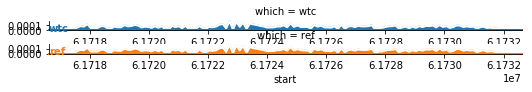

In [7]:
g = sns.FacetGrid(kde_df, row='which', hue='which', aspect=15, size=.5)
g.map(sns.kdeplot, 'start', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 'start', clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'start')

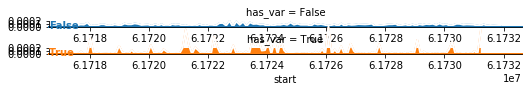

In [34]:
g = sns.FacetGrid(wtc_guides, row='has_var', hue='has_var', aspect=15, size=.5)
g.map(sns.kdeplot, 'start', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 'start', clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, 'start')

/Users/kathleen/miniconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


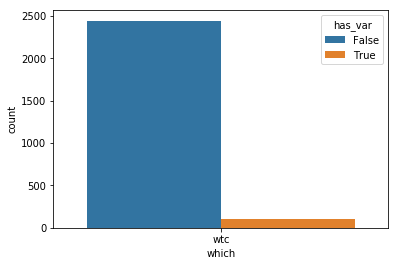

In [18]:
# simply evaluate number of guides per 

sns.countplot(x='which', hue='has_var', data=wtc_guides)

In [33]:
wtc_guides.query('has_var').shape[0]/wtc_guides.shape[0]

0.03858267716535433

# Figure 1b: most variants in 1KGP generate sgRNA sites

Generation of allele-specific CRISPR sites by heterozygous variants annotated in 1KGP (hg19 analysis), differentiated by whether they occur in a PAM or in the sgRNA recognition sequence. 

To figure out how the input data was processed, please see `ExcisionFinder/paper_figures/figure_scripts/ef_fig_1b.py`.

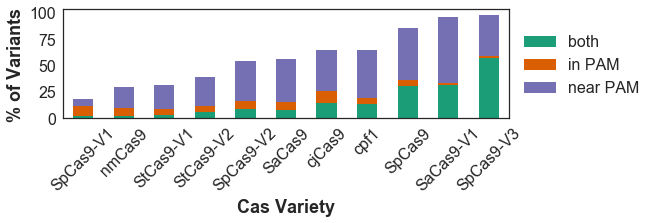

In [142]:
# load pre-compiled data
plotdf = pd.read_csv('figure_data/vars_near_in_df.tsv', sep='\t',
                    header=0, names=['cas','in PAM','near PAM','both'])

#sort by total variants that generate allele-specific PAM site
plotdf['total'] = plotdf[['in PAM','near PAM','both']].sum(axis=1)
plotdf['Cas'] = plotdf['cas'].replace(cas_dict)
plotdf = plotdf.sort_values(by='total')

# munge for plotting
plotdf.index = plotdf['Cas']

plotdf = plotdf[['both','in PAM','near PAM']]
plotdf = plotdf.multiply(100)

plotdf.plot.bar(stacked='True', color=sns.color_palette('Dark2'), figsize=(8,2))
plt.legend(bbox_to_anchor=(1.0, 0.5))
tickfont=16
plt.legend(bbox_to_anchor=(1.0, 0.9), fontsize=tickfont)
plt.xticks(rotation=45, fontsize=tickfont)
plt.yticks(fontsize=tickfont)
labelfont = 18
plt.ylabel('% of Variants', fontsize=labelfont,
          fontweight='bold')
plt.xlabel('Cas Variety', fontsize=labelfont, fontweight='bold')
plt.savefig('figures/fig1b.pdf', dpi=300, bbox_inches='tight')

# Figure 1d: dual > single for gene targeting
Gene targeting in WTC for a dual- versus single-cutting strategy. This figure considers only protein-coding genes with at least 2 heterozygous variants in the individual genome of WTC. 

fig_1d_dat.npy was generated using the script `figure_scripts/ef_fig_1d.py` using WTC single targ dfs and dual targ dfs on Pollard NAS. Single cut targetability of genes was determined using `manuscript_analyses/excisionFinder/wtc_hg19_analysis/src/single_cut_targ_wtc_hg19.py`. Dual targetability results were obtained using `manuscript_analyses/excisionFinder/wtc_hg19_analysis/src/ExcisionFinder_wtc_hg19.py`. 

In [144]:
cat_genes = np.load('figure_data/fig1_d_dat/fig_1d_dat.npy').item()

In [149]:
cat_genes.keys()

dict_keys(['Dual Targetable', 'Single Targetable', 'Dual Not Targetable', 'Single Not Targetable', 'No Coding Exons', 'Less Than 2 Het Variants', 'No Het Variants'])

In [176]:
new = {key:cat_genes[key] for key in ['Dual Targetable', 'Single Targetable']}
new['< 2 Het Variants'] = cat_genes['Less Than 2 Het Variants']

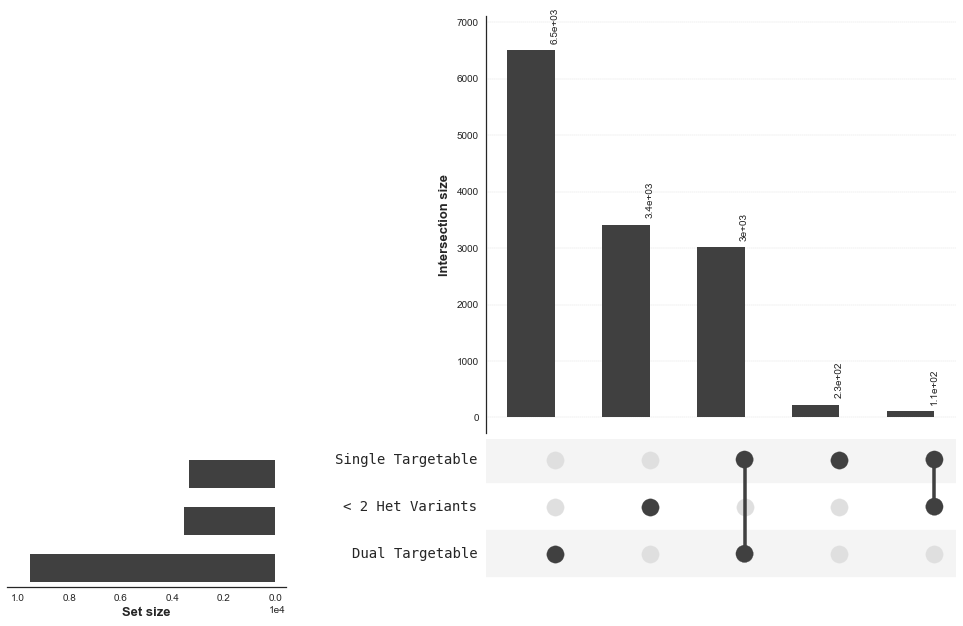

In [177]:
p = pyu.plot(new, inters_size_bounds=[1,30000])

In [178]:
p['figure'].savefig('figures/fig1d.pdf', dpi=300)

# Figure 1e: gene targetability varies by cas type and individual
Gene targetability variation by individual and Cas type. Overall df is generated with `figure_scripts/ef_fig_1e.py`

In [35]:
overall_df = pd.read_csv('figure_data/ef_fig_1e_hg19targ_per_gene_and_cas.tsv', sep='\t')
cas_list = overall_df.Cas.drop_duplicates().tolist()
with open('../manuscript_analyses/excisionFinder/hg19_analysis/dat/results_overview/genes_evaluated.txt','r') as f:
    eval_genes = f.read().splitlines()

# add not enough het variants in any ind genes
with open('../manuscript_analyses/excisionFinder/hg19_analysis/dat/results_overview/not_enough_hets.txt','r') as f:
    no_hets_inds = f.read().splitlines()

no_hets_inds_perc = [0.0] * (len(no_hets_inds) * len(cas_list))
no_hets_inds_cas = list(itertools.chain.from_iterable(itertools.repeat(cas_list, len(no_hets_inds))))
no_hets_inds_gene = list(itertools.chain.from_iterable(itertools.repeat(gene,len(cas_list)) for gene in no_hets_inds))

no_hets_df = pd.DataFrame({'% people targetable':no_hets_inds_perc,
                          'Cas':no_hets_inds_cas,
                          'Gene':no_hets_inds_gene})

# add no targetable inds genes
with open('../manuscript_analyses/excisionFinder/hg19_analysis/dat/results_overview/no_targetable_inds.txt','r') as f:
    no_targ_inds = f.read().splitlines()

no_targ_inds_perc = [0.0] * (len(no_targ_inds) * len(cas_list))
no_targ_inds_cas = list(itertools.chain.from_iterable(itertools.repeat(cas_list, len(no_targ_inds))))
no_targ_inds_gene = list(itertools.chain.from_iterable(itertools.repeat(gene,len(cas_list)) for gene in no_targ_inds))

no_targ_df = pd.DataFrame({'% people targetable':no_targ_inds_perc,
                          'Cas':no_targ_inds_cas,
                          'Gene':no_targ_inds_gene})

print('There are ' + str(len(no_targ_inds)+len(no_hets_inds)) + ' genes that are absolutely not targetable \
for dual excision in all samples from 1KGP cohort. Meanwhile, there are ' + str(len(eval_genes))
     + ' genes that had enough het variants in at least one individual and at least one individual with \
a potentially targetable pair.')

There are 138 genes that are absolutely not targetable for dual excision in all samples from 1KGP cohort. Meanwhile, there are 14792 genes that had enough het variants in at least one individual and at least one individual with a potentially targetable pair.


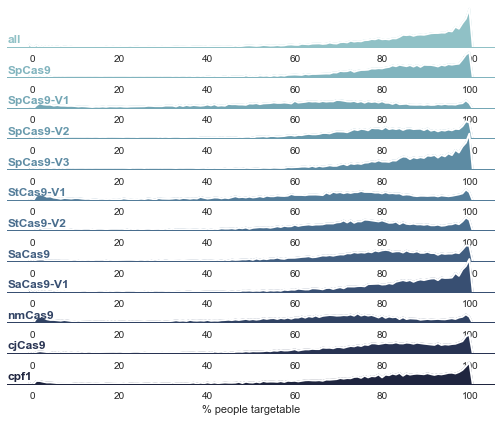

In [37]:
# inspired and helped by this page: https://seaborn.pydata.org/examples/kde_joyplot.html
plot_df = pd.concat([overall_df, no_targ_df, no_hets_df])

plot_df['% people targetable'] = plot_df['% people targetable']*100.0

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
cas_list = plot_df.Cas.drop_duplicates().tolist()
pal = sns.cubehelix_palette(len(cas_list), rot=-.25, light=.7)

g = sns.FacetGrid(plot_df, row='Cas', hue='Cas', aspect=15, size=.5, palette=pal)
g.map(sns.kdeplot, '% people targetable', shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, '% people targetable', color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, cas_dict[label], fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, '% people targetable')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig('figures/fig1e_targ_cas_ind_hg19.pdf', dpi=300, bbox_inches='tight')

In [38]:
overall_df = pd.read_csv('figure_data/ef_fig_1e_hg38targ_per_gene_and_cas.tsv', sep='\t')
cas_list = overall_df.Cas.drop_duplicates().tolist()
with open('../manuscript_analyses/excisionFinder/hg38_analysis/dat/results_overview/genes_evaluated.txt','r') as f:
    eval_genes = f.read().splitlines()

# add not enough het variants in any ind genes
with open('../manuscript_analyses/excisionFinder/hg38_analysis/dat/results_overview/not_enough_hets.txt','r') as f:
    no_hets_inds = f.read().splitlines()

no_hets_inds_perc = [0.0] * (len(no_hets_inds) * len(cas_list))
no_hets_inds_cas = list(itertools.chain.from_iterable(itertools.repeat(cas_list, len(no_hets_inds))))
no_hets_inds_gene = list(itertools.chain.from_iterable(itertools.repeat(gene,len(cas_list)) for gene in no_hets_inds))

no_hets_df = pd.DataFrame({'% people targetable':no_hets_inds_perc,
                          'Cas':no_hets_inds_cas,
                          'Gene':no_hets_inds_gene})

# add no targetable inds genes
with open('../manuscript_analyses/excisionFinder/hg38_analysis/dat/results_overview/no_targetable_inds.txt','r') as f:
    no_targ_inds = f.read().splitlines()

no_targ_inds_perc = [0.0] * (len(no_targ_inds) * len(cas_list))
no_targ_inds_cas = list(itertools.chain.from_iterable(itertools.repeat(cas_list, len(no_targ_inds))))
no_targ_inds_gene = list(itertools.chain.from_iterable(itertools.repeat(gene,len(cas_list)) for gene in no_targ_inds))

no_targ_df = pd.DataFrame({'% people targetable':no_targ_inds_perc,
                          'Cas':no_targ_inds_cas,
                          'Gene':no_targ_inds_gene})

print('There are ' + str(len(no_targ_inds)+len(no_hets_inds)) + ' genes that are absolutely not targetable \
for dual excision in all samples from 1KGP cohort. Meanwhile, there are ' + str(len(eval_genes))
     + ' genes that had enough het variants in at least one individual and at least one individual with \
a potentially targetable pair.')

There are 178 genes that are absolutely not targetable for dual excision in all samples from 1KGP cohort. Meanwhile, there are 14582 genes that had enough het variants in at least one individual and at least one individual with a potentially targetable pair.


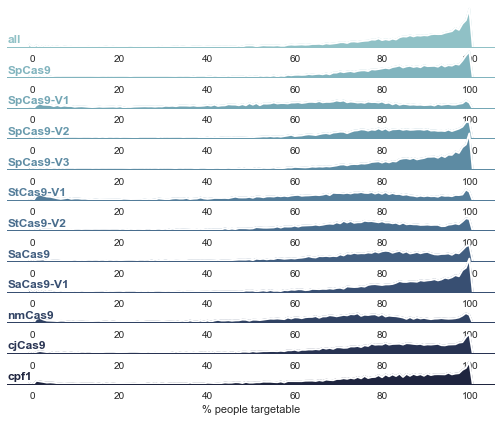

In [39]:
# inspired and helped by this page: https://seaborn.pydata.org/examples/kde_joyplot.html
plot_df = pd.concat([overall_df, no_targ_df, no_hets_df])

plot_df['% people targetable'] = plot_df['% people targetable']*100.0

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
cas_list = plot_df.Cas.drop_duplicates().tolist()
pal = sns.cubehelix_palette(len(cas_list), rot=-.25, light=.7)

g = sns.FacetGrid(plot_df, row='Cas', hue='Cas', aspect=15, size=.5, palette=pal)
g.map(sns.kdeplot, '% people targetable', shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, '% people targetable', color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, cas_dict[label], fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, '% people targetable')

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

g.savefig('figures/fig1e_targ_cas_ind_hg38.pdf', dpi=300, bbox_inches='tight')

### Mean # targetable genes per person

In [40]:
with open('../manuscript_analyses/excisionFinder/hg19_analysis/dat/genes_hg19.txt','r') as f:
    all_genes = f.read().splitlines()
    
len(all_genes)

25867

In [41]:
with open('../manuscript_analyses/excisionFinder/hg19_analysis/dat/results_overview/no_coding_exons.txt','r') as f:
    no_coding_exons = f.read().splitlines()
len(no_coding_exons)

10668

In [42]:
n_genes_eval = len(all_genes) - len(no_coding_exons)
print('Number of genes evaluated: ' + str(n_genes_eval))

Number of genes evaluated: 15199


`genes_per_person.npy` was produced with the script `figure_scripts/targ_genes_per_person.py`.

In [12]:
genes_to_ppl = np.load('figure_data/targ_genes_per_person_hg19genes_per_person.npy').item()

In [13]:
sums_dict = {}
for person in genes_to_ppl.keys():
    genes = genes_to_ppl[person]
    n_genes = len(genes)
    sums_dict[person] = n_genes

In [14]:
sums_df = pd.DataFrame.from_dict(sums_dict, orient='index')
sums_df.columns = ['n_genes']

In [20]:
mean_n_genes = sums_df['n_genes'].mean()
print('Mean # genes: ' + str(mean_n_genes))
print('Mean % genes: ' + str(mean_n_genes/n_genes_eval))

Mean # genes: 11672.0738818
Mean % genes: 0.76795012052


# Not all pairs have predicted high specificity scores


This is for SpCas9 in RHO in WTC (hg19). Note that there are multiple combinations of each pair, depending on whether ref or alt guide is used, here chose highest scoring pair possible at each pair position.

In [96]:
pairs = pd.read_csv('/Users/kathleen/rho_paper_analysis_wtc/wtc_hg19_pairs_guidespair_guides.tsv',
                   sep='\t')

In [97]:
scores_df = pd.read_csv('/Users/kathleen/rho_paper_analysis_wtc/rho_wtc_guides_crispor_guides.tsv', sep='\t')

In [115]:
def get_score_g1(row):
    alt_guide = row["gRNA_alt_guide_1"]
    if '--' in alt_guide:
        ref_guide = row["gRNA_ref_guide_1"]
        var = row['variant1']
        score = scores_df.query('gRNA_ref==@ref_guide and variant_position == @var')[['scores_ref', 'scores_alt']].values.max()
    else:
        var = row['variant1']
        score = scores_df.query('gRNA_alt==@alt_guide and variant_position == @var')[['scores_ref', 'scores_alt']].values.max()
    return score
        
def get_score_g2(row):
    alt_guide = row["gRNA_alt_guide_2"]
    if '--' in alt_guide:
        ref_guide = row["gRNA_ref_guide_2"]
        var = row['variant2']
        score = scores_df.query('gRNA_ref==@ref_guide and variant_position == @var')[['scores_ref', 'scores_alt']].values.max()
    else:
        var = row['variant2']
        score = scores_df.query('gRNA_alt==@alt_guide and variant_position == @var')[['scores_ref', 'scores_alt']].values.max()
    return score

In [116]:
pairs['score_guide_1'] = pairs.apply(get_score_g1, axis=1)
pairs['score_guide_2'] = pairs.apply(get_score_g2, axis=1)

In [117]:
pairs.head()

,variant1,variant2,gRNA_ref_guide_1,gRNA_alt_guide_1,ref_g1,alt_g1,variant_position_in_guide_g1,gRNA_ref_guide_2,gRNA_alt_guide_2,ref_g2,alt_g2,variant_position_in_guide_g2,score_guide_1,score_guide_2
0,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,TGGACGCTCTGGGTTTCCTG,TGGACGCTCTGGATTTCCTG,G,A,10.0,80,69
1,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,AGGAAACCCAGAGCGTCCAG,AGGAAATCCAGAGCGTCCAG,G,A,16.0,80,82
2,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,AGCAGAGCCGCTGGACGCTC,--------------------,G,A,0.0,80,84
3,129247526,129250566,CAGGCCTTCGCAGCATTCTT,CAGGCCTTCACAGCATTCTT,G,A,13.0,TGGACGCTCTGGGTTTCCTG,TGGACGCTCTGGATTTCCTG,G,A,10.0,77,69
4,129247526,129250566,CAGGCCTTCGCAGCATTCTT,CAGGCCTTCACAGCATTCTT,G,A,13.0,AGGAAACCCAGAGCGTCCAG,AGGAAATCCAGAGCGTCCAG,G,A,16.0,77,82


In [ ]:
pairs['passing'] = pairs['score_guide_1'] > filt and pairs['score_guide_2'] > filt

In [123]:
pairs['color'] = 'blue'
pairs['range_label'] = 'unassigned'

In [141]:
palette = itertools.cycle(sns.color_palette())

for n in range(0,100,10):
    color = next(palette)
    high=n+10
    pairs.loc[pairs.query('score_guide_1 > @n and score_guide_2 > @n').index,'color'] = str(color)
    pairs.loc[pairs.query('score_guide_1 > @n and score_guide_2 > @n').index,'range_label'] = f'{n}-{high}'

In [142]:
pairs.head()

,variant1,variant2,gRNA_ref_guide_1,gRNA_alt_guide_1,ref_g1,alt_g1,variant_position_in_guide_g1,gRNA_ref_guide_2,gRNA_alt_guide_2,ref_g2,alt_g2,variant_position_in_guide_g2,score_guide_1,score_guide_2,color,range_label
0,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,TGGACGCTCTGGGTTTCCTG,TGGACGCTCTGGATTTCCTG,G,A,10.0,80,69,"(0.29803921568627451, 0.44705882352941179, 0.6...",60-70
1,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,AGGAAACCCAGAGCGTCCAG,AGGAAATCCAGAGCGTCCAG,G,A,16.0,80,82,"(0.33333333333333331, 0.6588235294117647, 0.40...",70-80
2,129247526,129250566,TCAGGCCTTCGCAGCATTCT,TCAGGCCTTCACAGCATTCT,G,A,12.0,AGCAGAGCCGCTGGACGCTC,--------------------,G,A,0.0,80,84,"(0.33333333333333331, 0.6588235294117647, 0.40...",70-80
3,129247526,129250566,CAGGCCTTCGCAGCATTCTT,CAGGCCTTCACAGCATTCTT,G,A,13.0,TGGACGCTCTGGGTTTCCTG,TGGACGCTCTGGATTTCCTG,G,A,10.0,77,69,"(0.29803921568627451, 0.44705882352941179, 0.6...",60-70
4,129247526,129250566,CAGGCCTTCGCAGCATTCTT,CAGGCCTTCACAGCATTCTT,G,A,13.0,AGGAAACCCAGAGCGTCCAG,AGGAAATCCAGAGCGTCCAG,G,A,16.0,77,82,"(0.33333333333333331, 0.6588235294117647, 0.40...",70-80


In [ ]:
def get_color(row):
    if row['score_guide_1']

In [ ]:
fig, ax = plt.subplots()

colors = {'D':'red', 'E':'blue', 'F':'green', 'G':'black'}

ax.scatter(df['carat'], df['price'], c=df['color'].apply(lambda x: colors[x]))

plt.show()

# Figure 2a: greater targetability by including flanking regions around genes

This can now be better evaluated using flanking analysis. Should look at change in mean # of targetable genes per person.

In [ ]:
# swarmplot colored by super population


# Including specificity

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


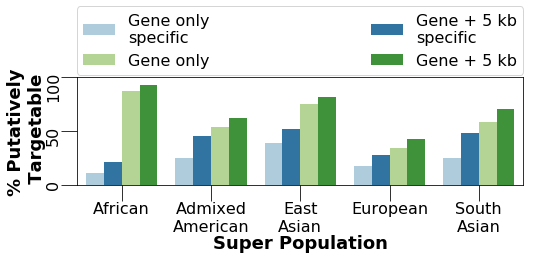

In [37]:
plt.rc("font", size=12)
plt.rcParams["font.family"] = "sans-serif"

# 5kb = more targetability

fig2, fig2_ax1 = plt.subplots(figsize=(8,2))
colors = list(sns.color_palette("Dark2", n_colors=4))

rho_5kb = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

# rho_5kb.query('targ_all').shape[0]/2504.0

rho_5kb_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop[superpop] = rho_5kb.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop[superpop] = rho_gene_only.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_propdf = pd.DataFrame.from_dict(rho_5kb_prop, orient='index')
rho_5kb_propdf.columns=['prop_targ']
rho_5kb_propdf['superpop'] = rho_5kb_propdf.index
# rho_5kb_propdf = rho_5kb_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_5kb_propdf['id'] = '5kb'

rho_gene_only_propdf = pd.DataFrame.from_dict(rho_gene_only_prop, orient='index')
rho_gene_only_propdf.columns=['prop_targ']
rho_gene_only_propdf['superpop'] = rho_gene_only_propdf.index
# rho_gene_only_propdf = rho_gene_only_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_gene_only_propdf['id'] = 'gene_only'

rho_5kb_spec = pd.read_hdf('../testing/sgRNAs_1kgp/spcas9/rho5kb_ef_output/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only_spec = pd.read_hdf('../testing/sgRNAs_1kgp/spcas9/rho5_ef_output/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

rho_5kb_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop_spec[superpop] = rho_5kb_spec.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop_spec[superpop] = rho_gene_only_spec.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_prop_specdf = pd.DataFrame.from_dict(rho_5kb_prop_spec, orient='index')
rho_5kb_prop_specdf.columns=['prop_targ']
rho_5kb_prop_specdf['superpop'] = rho_5kb_prop_specdf.index
rho_5kb_prop_specdf['id'] = '5kb_spec'

rho_gene_only_spec_propdf = pd.DataFrame.from_dict(rho_gene_only_prop_spec, orient='index')
rho_gene_only_spec_propdf.columns=['prop_targ']
rho_gene_only_spec_propdf['superpop'] = rho_gene_only_spec_propdf.index
rho_gene_only_spec_propdf['id'] = 'gene_only_spec'

plot_df = pd.concat([rho_5kb_propdf, rho_gene_only_propdf,
                    rho_gene_only_spec_propdf, rho_5kb_prop_specdf]).sort_values(by='prop_targ').replace(replace).replace(superpop_mapping)
plot_df['perc_targ'] = plot_df['prop_targ'] * 100.0

# colors = list(sns.color_palette("Dark2", n_colors=4))
# fig, ax = plt.subplots(figsize=(24, 6))
p = sns.barplot('superpop','perc_targ',hue='id', palette='Paired', data=plot_df, ax=fig2_ax1, order=['African','Admixed\nAmerican',
                                                                                                     'East\nAsian','European','South\nAsian'])
plt.ylim(0,100)
# labels = textwrap.wrap(l) for l in plot_df['superpop'].drop_duplicates().tolist()
handles, labels = fig2_ax1.get_legend_handles_labels()
handles = [handles[0],handles[2],handles[1],handles[3]]
labels = [labels[0],labels[2],labels[1],labels[3]]
fig2_ax1.legend(handles, labels,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.0,
               columnspacing=0.1, fontsize=16,markerscale=0.001)
# plt.xlabel('Population')
plt.ylabel('% Putatively\n Targetable', fontweight='bold',
          fontsize=18)
plt.xlabel('Super Population', fontsize=18, fontweight='bold')
fig2_ax1.tick_params(size=16, pad=0)
fig2_ax1.yaxis.labelpad = 0.02
fig2_ax1.xaxis.labelpad = 0
plt.yticks(np.arange(0,101, 50.0),rotation=90, fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('figures/fig5_poster.pdf', dpi=300, bbox_inches='tight')

# Figure 2c: set cover optimization enables targeting of many people with few sgRNA pairs

Proportion of targetable individuals per population based on the definition from Figure 1b, and proportion that would be covered by at least one of five set-cover-optimized sgRNA pairs.

## Option 1

Prop targetable overall is 0.7312300319488818
Prop covered overall by 5 optimal sgRNAs is 0.5766773162939297
Prop covered of targetable by 5 optimal sgRNAs is 0.7886400873839432


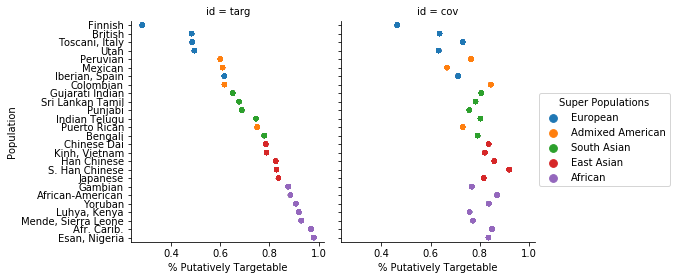

In [30]:
pop_dict = {'CHB':'Han Chinese',
           'JPT':'Japanese',
           'CHS':'S. Han Chinese',
           'CDX':'Chinese Dai',
           'KHV':'Kinh, Vietnam',
           'CEU':'Utah',
           'TSI':'Toscani, Italy',
           'FIN':'Finnish',
           'GBR':'British',
           'IBS':'Iberian, Spain',
           'YRI':'Yoruban',
           'LWK':'Luhya, Kenya',
           'GWD':'Gambian',
           'MSL':'Mende, Sierra Leone',
           'ESN':'Esan, Nigeria',
           'ASW':'African-American',
           'ACB':'Afr. Carib.',
           'MXL':'Mexican',
           'PUR':'Puerto Rican',
           'CLM':'Colombian',
           'PEL':'Peruvian',
           'GIH':'Gujarati Indian',
           'PJL':'Punjabi',
           'BEB':'Bengali',
           'STU':'Sri Lankan Tamil',
           'ITU':'Indian Telugu',
           'EUR':'European',
           'SAS':'South Asian',
           'AMR':'Admixed American',
           'AFR':'African',
           'EAS':'East Asian'}

colors = list(sns.color_palette("Dark2", n_colors=5))

targ_dat = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')

targ_pops = targ_dat.merge(sample_legend, how='left')

plot_dict = {}

for pop in list(set(sample_legend['pop'].tolist())):
    plot_dict[pop] = targ_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df = pd.DataFrame.from_dict(plot_dict, orient='index')
plot_df['pop'] = plot_df.index
plot_df.columns=['perc_targ','pop']
plot_df = plot_df.merge(sample_legend)
plot_df = plot_df.sort_values(by='perc_targ')

ppl_cov_five = pd.read_csv('plotting_data/RHO_5kb_setcover__ppl_covered.txt', header=None,
                          names=['sample'])

ppl_cov_five = ppl_cov_five.merge(sample_legend)

plot_dict_cov = {}

for pop in list(set(plot_df['pop'].tolist())):
#     print(pop)
    plot_dict_cov[pop] = ppl_cov_five.query('pop == @pop').shape[0]/targ_dat.query('pop == @pop and targ_all').shape[0]

plot_df_final = pd.DataFrame.from_dict(plot_dict_cov, orient='index')
plot_df_final['pop'] = plot_df_final.index
plot_df_final.columns=['perc_targ','pop']
plot_df_final = plot_df_final.merge(sample_legend)

plot_df['id'] = 'targ'
plot_df_final['id'] = 'cov'

dual = pd.concat([plot_df, plot_df_final])
dual.to_csv('plotting_data/rho_5kb_plot_df.tsv', sep='\t', index=False)

p = sns.factorplot(x='perc_targ', y='pop', hue='superpop',col='id', data=dual.replace(pop_dict), kind='strip')
p.set_axis_labels('% Putatively Targetable','Population')
p._legend.set_title('Super Populations')
print('Prop targetable overall is ' + str(targ_dat.query('targ_all').shape[0]/len(all_samples)))
print('Prop covered overall by 5 optimal sgRNAs is ' +str(ppl_cov_five.shape[0]/len(all_samples)))
print('Prop covered of targetable by 5 optimal sgRNAs is ' +str(ppl_cov_five.shape[0]/targ_dat.query('targ_all').shape[0]))

# p.savefig('figures/rho5kb_targ_cov_five_common.pdf', dpi=300)

In [9]:
# ppl_cov_five.shape[0]/rho_pops.query('targ_all').shape[0]

ppl_cov_five.shape[0]/len(all_samples)

0.5766773162939297

## Option 2

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


(array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 7 Text yticklabel objects>)

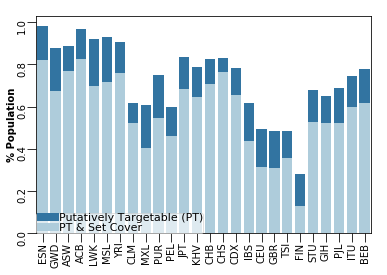

In [5]:
sample_legend = sample_legend.query('sample in @all_samples')
targ_dat = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')

targ_pops = targ_dat.merge(sample_legend, how='left')

plot_dict = {}

for pop in list(set(sample_legend['pop'].tolist())):
    plot_dict[pop] = targ_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df = pd.DataFrame.from_dict(plot_dict, orient='index')
plot_df['pop'] = plot_df.index
plot_df.columns=['perc_targ','pop']
plot_df = plot_df.merge(sample_legend, how='left')
plot_df = plot_df.sort_values(by='perc_targ')

ppl_cov_five = pd.read_csv('plotting_data/RHO_5kb_setcover__ppl_covered.txt', header=None,
                          names=['sample'])

ppl_cov_five = ppl_cov_five.merge(sample_legend)

plot_dict_cov = {}

for pop in list(set(plot_df['pop'].tolist())):
#     print(pop)
    plot_dict_cov[pop] = ppl_cov_five.query('pop == @pop').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df_final = pd.DataFrame.from_dict(plot_dict_cov, orient='index')
plot_df_final['pop'] = plot_df_final.index
plot_df_final.columns=['perc_targ','pop']
plot_df_final = plot_df_final.merge(sample_legend, how='left')

plot_df['id'] = 'targ'
plot_df_final['id'] = 'cov'

dual = pd.concat([plot_df, plot_df_final])
# dual.to_csv('plotting_data/rho_5kb_plot_df.tsv', sep='\t', index=False)

order_vector = dual.sort_values(by='superpop')['pop'].drop_duplicates().tolist()

colors = list(sns.color_palette("Paired", n_colors=4))
p = sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "targ"'),
            label="Putatively Targetable (PT)", color=colors[1], order=order_vector)
sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "cov"'),
            label="PT & Set Cover", color=colors[0], order=order_vector)
plt.ylabel('% Population', fontweight='bold')
plt.xlabel('')
plt.setp(p.get_xticklabels(), rotation=90)
p.legend(frameon=True, ncol=1, loc='lower left',handletextpad=0.01,
                columnspacing=0.1, fontsize=11,markerscale=0.001,borderaxespad=0,
               labelspacing=0,borderpad=0.03,framealpha=0.6)
p.tick_params(size=9, pad=0.0)
p.yaxis.labelpad = 0
p.xaxis.labelpad = 0
plt.yticks(rotation=90)

# fig2.set_size_inches(4.5,4.5)

## Super Pops only

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


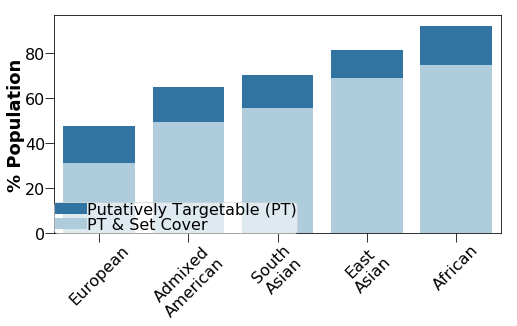

In [23]:
sample_legend = sample_legend.query('sample in @all_samples')
targ_dat = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')

targ_pops = targ_dat.merge(sample_legend, how='left')

plot_dict = {}

for pop in list(set(sample_legend['superpop'].tolist())):
    plot_dict[pop] = targ_pops.query('superpop == @pop and targ_all').shape[0]/sample_legend.query('superpop == @pop').shape[0]

plot_df = pd.DataFrame.from_dict(plot_dict, orient='index')
plot_df['pop'] = plot_df.index
plot_df.columns=['perc_targ','pop']
plot_df = plot_df.merge(sample_legend, how='left')
plot_df = plot_df.sort_values(by='perc_targ')

ppl_cov_five = pd.read_csv('plotting_data/RHO_5kb_setcover__ppl_covered.txt', header=None,
                          names=['sample'])

ppl_cov_five = ppl_cov_five.merge(sample_legend)

plot_dict_cov = {}

for pop in list(set(sample_legend['superpop'].tolist())):
#     print(pop)
    plot_dict_cov[pop] = ppl_cov_five.query('superpop == @pop').shape[0]/sample_legend.query('superpop == @pop').shape[0]

plot_df_final = pd.DataFrame.from_dict(plot_dict_cov, orient='index')
plot_df_final['pop'] = plot_df_final.index
plot_df_final.columns=['perc_targ','pop']
plot_df_final = plot_df_final.merge(sample_legend, how='left')

plot_df['id'] = 'targ'
plot_df_final['id'] = 'cov'

dual = pd.concat([plot_df, plot_df_final])
dual = dual.replace(replace)
dual['perc_targ'] = dual['perc_targ'] * 100.0
# dual.to_csv('plotting_data/rho_5kb_plot_df.tsv', sep='\t', index=False)
order_vector = dual.sort_values(by='superpop')['pop'].drop_duplicates().tolist()

colors = list(sns.color_palette("Paired", n_colors=4))

fig, ax = plt.subplots(figsize=(8,4))
p = sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "targ"'),
            label="Putatively Targetable (PT)", color=colors[1], order=order_vector)
sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "cov"'),
            label="PT & Set Cover", color=colors[0], order=order_vector)
plt.ylabel('% Population', fontsize=18, fontweight='bold')
plt.xlabel('')
plt.setp(p.get_xticklabels(), rotation=90)
p.legend(frameon=True, ncol=1, loc='lower left',handletextpad=0.01,
                columnspacing=0.1, fontsize=16,markerscale=0.001,borderaxespad=0,
               labelspacing=0,borderpad=0.03,framealpha=0.6)
p.tick_params(size=9, pad=0.0)
p.yaxis.labelpad = 0
p.xaxis.labelpad = 0
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# p.Fig.set_size_inches(8, 4)

plt.savefig('figures/poster_set_cover.pdf', dpi=300, bbox_inches='tight')

# Supplementary Figure 4: Different populations have different #s of targ genes

Mean % genes putatively targetable in individuals from various populations from 1KGP.

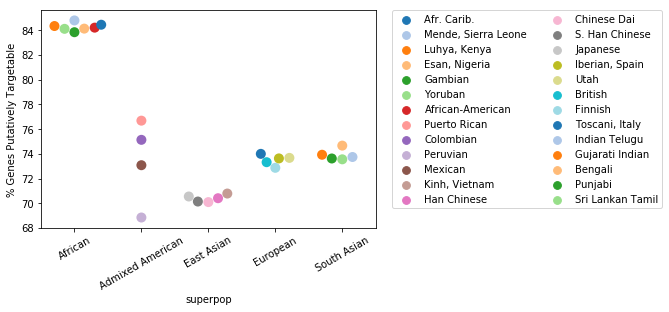

In [19]:
genes_eval = len(np.load('../data/genes_evaluated.npy').tolist())

dat = pd.read_csv('../data/targ_genes_per_person.tsv', sep='\t')
dat.columns = ['sample','n_genes_targ']
dat['%_genes_targ'] = 100.0*(dat['n_genes_targ'] / genes_eval)
dat = dat.merge(sample_legend)

np.mean(dat['%_genes_targ'])

agg = dat.groupby('pop').mean()
agg['pop'] = agg.index
agg = agg.merge(sample_legend[['pop','superpop']]).drop_duplicates().reset_index(drop=True).sort_values(by='superpop')

# sns.violinplot(x='superpop', y='n_genes_targ', 
#                hue='superpop', data=agg, palette='tab20', inner=None)
p = sns.swarmplot(x='superpop', y='%_genes_targ', hue='pop',
               data=agg.replace(pop_dict), palette='tab20', size=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, ncol=2)
plt.ylabel('% Genes Putatively Targetable')
plt.setp(p.get_xticklabels(), rotation=30)
# plt.savefig('figures/targ_genes_per_person.pdf', dpi=300,
#            bbox_inches='tight')

# Supplementary Figure 5: Specificity Scores for 10 Genes

Distribution of specificity scores for ten genes. Median is indicated, with upper and lower bounds of the box indicating quartiles of the data range.

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

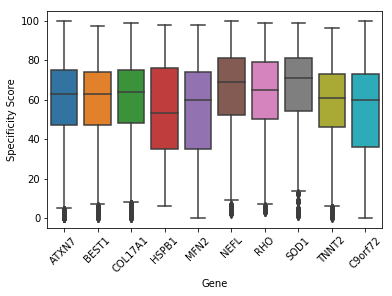

In [29]:
# gene_list = ['atxn7','best1','col17a1','hspb1','mfn2','nefl','rho','sod1','tnnt2','C9orf72']
gene_list = ['ATXN7','BEST1','COL17A1','HSPB1','MFN2','NEFL','RHO','SOD1','TNNT2','C9orf72']

genes_dict_mit = {}

def load_gene_mit(gene):
    df = pd.read_csv(f'../testing/gene_crispor_scores/nosave_{gene}_ref_scores.tsv', sep='\t',
                    header=0, index_col=False, names=['seqID', 'guideID', 'targetSeq', 'mitSpecScore',
                                     'offtargetcount','targetGenomeGeneLocus','1','2','3']).dropna()
    df[['mitSpecScore']] = df[['mitSpecScore']].apply(pd.to_numeric)
    return(df)

for gene in gene_list:
    genes_dict_mit[gene] = load_gene_mit(gene)

# these are currently only for SpCas9

def perc_cuttable(df):
    output = df.query('mitSpecScore > 50').shape[0]/df.shape[0]
    return(output)

def get_plot_version(df, name):
    out = df[['mitSpecScore']]
    out['gene'] = name
    out.columns = ['score','gene']
    return(out)

out_list = []
out_perc_list = []

for gene in genes_dict_mit.keys():
#     print(gene)
    plot_df = get_plot_version(genes_dict_mit[gene], gene)
    out_list.append(plot_df)
    out_perc_list.append(perc_cuttable(genes_dict_mit[gene]))
#     print(gene,perc_cuttable(genes_dict[gene]))

complete_mit = pd.concat(out_list)
complete_mit['score_type'] = 'Specificity'
# print(np.mean(out_perc_list))

# sns.boxplot(complete_mit)
# complete_mit.head()
p=sns.boxplot(x = 'gene', y='score',data=complete_mit)
plt.ylabel('Specificity Score')
plt.xlabel('Gene')
plt.setp(p.get_xticklabels(), rotation=45)

# Supplementary Figure 2: PAM motif occurrences in hg19 are correlated with their size. 

PAM size as a function of motif occurrences in the reference genome hg19. Shading indicates the 95% confidence interval. PAM size does not include N positions, and uses the smallest of motif options for a Cas.

PAM table: 

| **Cas Type** | **PAM Site** | **PAM Size** |
| --- | --- | --- |
| SpCas9 | NGG | 2 |
| SpCas9-V1 | NGCG | 3 |
| SpCas9-V2 | NGAG | 3 |
| SpCas9-V3 | NGAN or NGNG | 2 |
| SaCas9 | NNGRRT | 4 |
| SaCas9-V1 | NNNRT | 2 |
| nmCas9 | NNNNGATT | 4 |
| cpf1 | TTTN | 3 |
| StCas9-V1 | NNAGAA | 4 |
| StCas9-V2 | NGGNG | 4 |
| cjCas9 | NNNNACA | 3 |

`figure_data/hg19_pams_per_cas.npy` is generated using `figure_scripts/get_n_occurences_pams.py` using PAM data generated with `preprocessing/find_pams_in_reference/pam_pos_genome.py` with hg19.fa downloaded from UCSC.

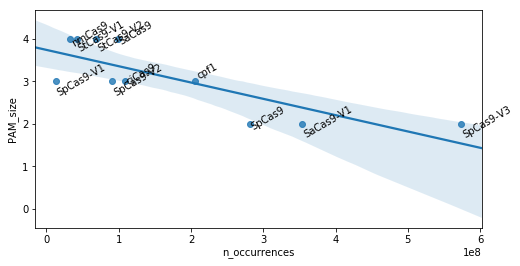

In [90]:
pam_sizes = {'SpCas9':2, 'SpCas9-V1':3, 'SpCas9-V2':3, 'SpCas9-V3':2, 
             'SaCas9':4, 'SaCas9-V1':2, 'nmCas9':4, 'cpf1':3, 
             'StCas9-V1':4, 'StCas9-V2':4, 'cjCas9':3}

pam_presence_dict = np.load('figure_data/hg19_pams_per_cas.npy').item()
pam_presence_df = pd.DataFrame.from_dict(pam_presence_dict, orient='index')
pam_presence_df.columns = ['n_occurrences']
pam_presence_df['Cas'] = pam_presence_df.index
cas_list = list(pam_sizes.keys())
pam_presence_df = pam_presence_df.replace(cas_dict)
pam_presence_df['in_list'] = pam_presence_df['Cas'].isin(cas_list)
pam_presence_df = pam_presence_df.query('in_list')[['n_occurrences','Cas']]
pam_presence_df['PAM_size'] = pam_presence_df.apply(lambda row: pam_sizes[row['Cas']], axis=1)

pam_presence_df.sort_values(by='n_occurrences', ascending=False)

# plot relationship of PAM size to presence in genome
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)
p = sns.regplot('n_occurrences', 'PAM_size', data=pam_presence_df, ci=95)
counter = -1
for cas in pam_presence_df.Cas.tolist():
    counter += 1
    if cas == 'cjCas9':
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter]+0.6,
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))
    else:
        p.annotate(cas, xy=(pam_presence_df.n_occurrences.tolist()[counter],pam_presence_df.PAM_size.tolist()[counter]),
              rotation=30, xytext=(pam_presence_df.n_occurrences.tolist()[counter],
                                   pam_presence_df.PAM_size.tolist()[counter]+0.28))
    
# plt.savefig('paper_figures/pams_vs_size_hg19.pdf', dpi=300)

In [91]:
# calculate Spearman correlation between size and presence

from scipy.stats import spearmanr

spearmanr(pam_presence_df['PAM_size'], pam_presence_df['n_occurrences'])

SpearmanrResult(correlation=-0.75125127531618408, pvalue=0.00769224521263404)

In [92]:
# calculate Pearson correlation between size and presence

from scipy.stats import pearsonr

pearsonr(pam_presence_df['PAM_size'], pam_presence_df['n_occurrences'])

(-0.79468700171501927, 0.0034712629690476036)

In [93]:
pam_presence_df.sort_values(by='PAM_size')

,n_occurrences,Cas,PAM_size
SpCas9_VQR,574388160,SpCas9-V3,2
SpCas9,281005914,SpCas9,2
SaCas9_KKH,353751593,SaCas9-V1,2
SpCas9_VRER,12967542,SpCas9-V1,3
SpCas9_EQR,90763866,SpCas9-V2,3
cjCas9,108040050,cjCas9,3
cpf1,205859166,cpf1,3
StCas9,41959549,StCas9-V1,4
StCas9_2,68606312,StCas9-V2,4
SaCas9,98743451,SaCas9,4


In [94]:
pam_presence_df.sort_values(by='n_occurrences', ascending=False)

,n_occurrences,Cas,PAM_size
SpCas9_VQR,574388160,SpCas9-V3,2
SaCas9_KKH,353751593,SaCas9-V1,2
SpCas9,281005914,SpCas9,2
cpf1,205859166,cpf1,3
cjCas9,108040050,cjCas9,3
SaCas9,98743451,SaCas9,4
SpCas9_EQR,90763866,SpCas9-V2,3
StCas9_2,68606312,StCas9-V2,4
StCas9,41959549,StCas9-V1,4
nmCas9,32771942,nmCas9,4


# Supplementary Figure 3: dual cuts > single cuts WTC

Protein-coding gene targetability genome-wide in WTC with a single- and dual-cutting strategy.

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


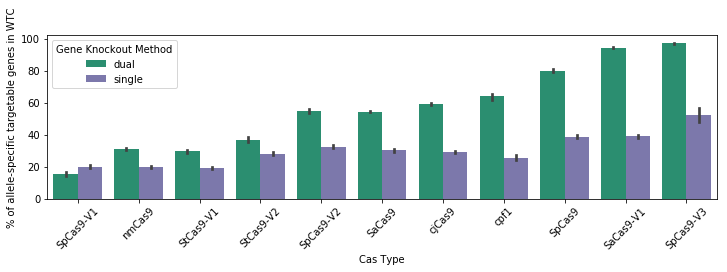

In [21]:
def n_targ_genes(chrom, cas='all'):
    df = pd.read_csv(f'../wtc_ef/single_cut_targetable_genes/chr{chrom}/chr{chrom}_single_var_targ_genes.tsv', sep='\t')
    n_targs = df[cas].sum()
    n_genes = df.shape[0]
    percent_genes = (n_targs/n_genes)*100.0
    return(percent_genes)

def n_targ_genes_v3(chrom):
    df = pd.read_csv(f'../wtc_ef/single_cut_targetable_genes/chr{chrom}/chr{chrom}_single_var_targ_genes.tsv', sep='\t')
    targs1 = df['gene'][df['SpCas9_VQR_1']].tolist()
    targs2 = df['gene'][df['SpCas9_VQR_2']].tolist()
    genes = targs1 + targs2
    n_targs = len(genes)
    n_genes = df.shape[0]
    perc_targ = (n_targs/n_genes)*100.0
    return(perc_targ)

CAS_LIST = ['all', 'SpCas9', 'SpCas9_VRER', 'SpCas9_EQR', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'StCas9', 'StCas9_2',
            'SaCas9', 'SaCas9_KKH', 'nmCas9',
            'cjCas9', 'cpf1']

cases2 = {'Cas9':'SpCas9',
 'Cas9-V1':'SpCas9-V1',
 'Cas9-V2':'SpCas9-V2',
 'Cas9-V3':'SpCas9-V3',
 'SaCas9':'SaCas9',
 'SaCas9-V1':'SaCas9-V1',
 'StCas9-2':'StCas9-V2',
 'StCas9-V1':'StCas9-V1'}
colors = list(sns.color_palette("Dark2", n_colors=4))

cas_list = []
chromosome = []
perc_targ_vars = []

chroms = list(range(1,23))
for chrom in chroms:
    for cas in CAS_LIST:
        perc_targ = n_targ_genes(chrom, cas)
        cas_list.append(cas)
        chromosome.append(chromosome)
        perc_targ_vars.append(perc_targ)
    cas_list.append('SpCas9-V3')
    chromosome.append(chrom)
    perc_targ_vars.append(n_targ_genes_v3(chrom))

wtc_singles = pd.DataFrame({'cas':cas_list, 'chromosome':chromosome, 'perc_targ_vars':perc_targ_vars})
wtc_singles.replace(to_replace=cas_dict, inplace=True)
wtc_singles['targ_type'] = 'single'

wtc_var_plot_df = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_var_plot_df.tsv', sep='\t')
# wtc_var_plot_df.head()

wtc_var_plot_df.replace(to_replace=cases2, inplace=True)
wtc_var_plot_df['perc_targ_vars'] = wtc_var_plot_df['prop_targ_vars'] * 100.0
wtc_var_plot_df['chromosome'] = wtc_var_plot_df['chromosomes']
wtc_var_plot_df = wtc_var_plot_df[['cas','chromosome','perc_targ_vars']]
wtc_var_plot_df['targ_type'] = 'dual'
# wtc_var_plot_df.head()

wtc_var_targ_plot_df = pd.concat([wtc_singles, wtc_var_plot_df]).replace(to_replace = cases2)
wtc_var_targ_plot_df.sort_values(by='perc_targ_vars', inplace=True)

fig, ax = plt.subplots(figsize=(12, 3))
p = sns.barplot(x='cas', y='perc_targ_vars', hue='targ_type', 
                order=['SpCas9-V1','nmCas9','StCas9-V1','StCas9-V2',
                       'SpCas9-V2','SaCas9','cjCas9', 'cpf1', 
                       'SpCas9','SaCas9-V1','SpCas9-V3'],palette={'single':colors[2],'dual':colors[0]}, data=wtc_var_targ_plot_df)
p.set(xlabel='Cas Type', ylabel='% of allele-specific targetable genes in WTC')
plt.setp(p.get_xticklabels(), rotation=45)
l = ax.legend()
l.set_title('Gene Knockout Method')
# fig.savefig('figures/supp_fig_3.pdf', dpi=300, bbox_inches='tight')

# Supplementary Figure 6: gene targetability of difficult-to-target large genes from WTC in 1KGP by population

Putative targetability of difficult-to-target large genes from WTC in 1KGP populations.

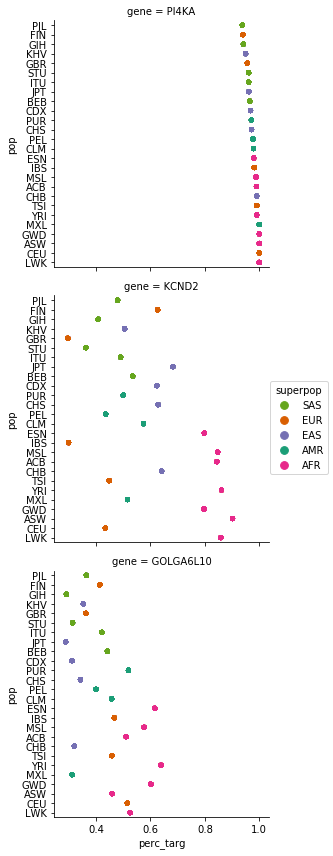

In [21]:
colors = list(sns.color_palette("Dark2", n_colors=5))

genes = {'PI4KA':'22','KCND2':'7','GOLGA6L10':'15'}

plot_dicts = []

for gene in genes.keys():
    chrom = genes[gene]
    rp1 = pd.read_hdf(f'/pollard/data/1kg/ef/gene_targ_outputs/chr{chrom}/chr{chrom}_out.hdf5',f'{gene}')

    rp1_pops = rp1.merge(sample_legend, how='left')

    plot_dict_rp1 = {}

    for pop in sample_legend['pop'].tolist():
        plot_dict_rp1[pop] = rp1_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

    plot_df_rp1 = pd.DataFrame.from_dict(plot_dict_rp1, orient='index')
    plot_df_rp1['pop'] = plot_df_rp1.index
    plot_df_rp1.columns=['perc_targ','pop']
    plot_df_rp1 = plot_df_rp1.merge(sample_legend)
    plot_df_rp1 = plot_df_rp1.sort_values(by='perc_targ')
    plot_df_rp1['gene'] = gene
    plot_df_rp1['type'] = 'large'
    plot_dicts.append(plot_df_rp1)
    
plot_df = pd.concat(plot_dicts)


p = sns.factorplot(x='perc_targ', y='pop', hue='superpop',row='gene', 
                   data=plot_df, kind='strip',
                  palette = {'AMR':colors[0], 'EUR':colors[1],
                            'EAS':colors[2],'AFR':colors[3],
                            'SAS':colors[4]})

p.savefig(f'figures/wtc_big_genes_targ_pops.pdf', dpi=300)

# Supplementary Figure NOT USED: Different #s of sites targetable inds

Even targetable individuals have varying numbers of allele-specific CRISPR sites.

In [4]:
transcript = get_canonical('RHO', gene_annots)

rho_start = gene_annots.query('name == @transcript').txStart.item()
rho_stop = gene_annots.query('name == @transcript').txEnd.item()

rho_5kb_start = rho_start - 5000
rho_5kb_stop = rho_stop + 5000

rho_vars = pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr3_targ.hdf5','all', where='pos <= rho_stop and pos >= rho_start')
rho_5kb_vars = pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr3_targ.hdf5','all', where='pos <= rho_5kb_stop and pos >= rho_5kb_start')

rho_gens = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/hap_targ_ind_3.hdf5','RHO')
rho_5kb_gens = pd.read_hdf('plotting_data/RHO_5kb/hap_targ_ind_3.hdf5','RHO')

rho_gens.columns

CAS_LIST = ['SpCas9', 'SpCas9_VRER', 'SpCas9_EQR', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'StCas9', 'StCas9_2',
            'SaCas9', 'SaCas9_KKH', 'nmCas9',
            'cjCas9', 'cpf1']
samp_dict_rho = {}
samp_dict_rho_5kb = {}

for cas in CAS_LIST:
    samp_dict_rho[cas] = {}
    if cas == 'SpCas9_VQR_1':
        for sample in all_samples:
            if rho_gens.query('sample == @sample').empty:
                samp_dict_rho[cas][sample] = 0
            else:
                samp_dict_rho[cas][sample] = rho_gens.query(f'(sample == @sample and hap1_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap1_SpCas9_VQR_2) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_2)').shape[0]
    elif cas == 'SpCas9_VQR_2':
        continue
    else:
        for sample in all_samples:
            if rho_gens.query('sample == @sample').empty:
                samp_dict_rho[cas][sample] = 0
            else:
                samp_dict_rho[cas][sample] = rho_gens.query(f'(sample == @sample and hap1_{cas}) \
                or (sample == @sample and hap2_{cas})').shape[0]
                
for cas in CAS_LIST:
    samp_dict_rho_5kb[cas] = {}
    if cas == 'SpCas9_VQR_1':
        for sample in all_samples:
            if rho_5kb_gens.query('sample == @sample').empty:
                samp_dict_rho_5kb[cas][sample] = 0
            else:
                samp_dict_rho_5kb[cas][sample] = rho_5kb_gens.query(f'(sample == @sample and hap1_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_1) \
                                                   or (sample == @sample and hap1_SpCas9_VQR_2) \
                                                   or (sample == @sample and hap2_SpCas9_VQR_2)').shape[0]
    elif cas == 'SpCas9_VQR_2':
        continue
    else:
        for sample in all_samples:
            if rho_5kb_gens.query('sample == @sample').empty:
                samp_dict_rho_5kb[cas][sample] = 0
            else:
                samp_dict_rho_5kb[cas][sample] = rho_5kb_gens.query(f'(sample == @sample and hap1_{cas}) \
                or (sample == @sample and hap2_{cas})').shape[0]

df_list = []

for cas in samp_dict_rho.keys():
    df = pd.DataFrame.from_dict(samp_dict_rho[cas], orient='index')
#     df.columns = ['n_targ_sites']
    df['cas'] = cas
    df['type'] = 'gene'
#     df['sample'] = df.index
    df_list.append(df)
    df2 = pd.DataFrame.from_dict(samp_dict_rho_5kb[cas], orient='index')
#     df.columns = ['n_targ_sites']
    df2['cas'] = cas 
    df2['type'] = '5kb'
#     df['sample'] = df.index
    df_list.append(df2)

plot_df = pd.concat(df_list)
plot_df.columns = ['n_sites','cas','type']
plot_df = plot_df.sort_values(by='type', ascending=False)
plot_df.head()

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
g = sns.FacetGrid(plot_df, row='cas', hue='type', aspect=15, size=0.7, palette='Dark2')
g.map(plt.hist, 'n_sites', alpha=0.4)
# g.map(sns.kdeplot, "n_sites", clip_on=False, color="w", lw=2, bw=.2)
# g.map(plt.axhline, y=0, lw=2, clip_on=False)
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color, 
#             ha="left", va="center", transform=ax.transAxes)

g.map(label, "n_sites")
g.fig.subplots_adjust(hspace=-.25)

# Supplementary Table 3: gene groups WTC

Summary of gene groups in WTC. 

In [ ]:
allwtrans = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_allwtrans.tsv', sep='\t')
scipy.stats.iqr(allwtrans.query('gene_group == "targetable"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "targetable"')['size'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not targetable"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not targetable"')['size'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not enough hets"')['n_exons'].tolist())

scipy.stats.iqr(allwtrans.query('gene_group == "not enough hets"')['size'].tolist())

allwtrans.query('gene_group != "no coding exons"').groupby(['gene_group']).median()

# Supplementary Table 5: exons, chromosome, size, mean # hets for difficult-to-target genes 1KGP

In [45]:
gene_list = ['CXCR4','TNP1','SMIM4','FRG2','DEFB105B','NPIPA3',
             'NPIPA2','NPIPB13','PYCARD','SPATA25']

gene_dict = {}

def get_dat_gene(gene):
    transcript = get_canonical(gene, gene_annots)
    chrom, start, stop = gene_annots.query('name == @transcript')[['chrom','txStart','txEnd']].iloc[0].tolist()
    chrom = chrom[3:]
    return(chrom, start, stop)

def het(genotype):
    gen1, gen2 = genotype.split('|')
    return(gen1 != gen2)

for gene in gene_list:

    c, s, st = get_dat_gene(gene)

    # load genotypes

    hdf = pd.HDFStore(f'/pollard/data/1kg/excisionFinderData/1kg_gen_dfs/chr{c}_gens.hdf5')
    gens = pd.read_hdf(hdf, where='index >= s and index <= st')

    het_gens = gens.applymap(het)

    ind_gens = {}

    for ind in all_samples:
        ind_gens[ind] = float(het_gens[ind].sum(axis=0))

    ind_gens_df = pd.DataFrame.from_dict(ind_gens, orient='index')
    ind_gens_df['sample'] = ind_gens_df.index
    ind_gens_df.columns = ['n_hets','sample']

    ind_gens_df = ind_gens_df.merge(sample_legend)
    
    superpops = ind_gens_df['superpop'].drop_duplicates().tolist()
    pops = ind_gens_df['pop'].drop_duplicates().tolist()

    mean_hets = {}
    
    mean_hets['overall'] = np.mean(ind_gens_df['n_hets'])
    
    for superpop in superpops:
        mean_hets[superpop] = np.mean(ind_gens_df.query('superpop == @superpop')['n_hets'])
        
    for pop in pops:
        mean_hets[pop] = np.mean(ind_gens_df.query('pop == @pop')['n_hets'])
        
    gene_dict[gene] = mean_hets

hets_df = pd.DataFrame.from_dict(gene_dict, orient='index').sort_index()

# hets_df.to_csv('hardtotarget_genes_1kgp.tsv', sep='\t', index=False)

# Figure 1: all subplots

all
SpCas9_VQR_1
SpCas9_VQR_2
SpCas9
SpCas9_VRER
SaCas9
SaCas9_KKH
cpf1


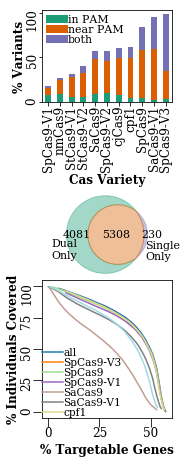

In [108]:
labs = pd.read_csv('fig1b_data.tsv', sep='\t')

plotdf = pd.read_csv('fig1b_data.tsv', sep='\t')[['in PAM','near PAM','both']]
plotdf = plotdf * 100.0
plotdf['cas'] = labs['cas']

fig1 = plt.figure()
plt.rc("font", size=12)
plt.rc('font',family='Serif')
# gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[2,1,2], wspace=0.1) 
gs = gridspec.GridSpec(nrows=5, ncols=5, height_ratios=[1,0.95,1,0,1.5]) 
gs.update(wspace=0.0, hspace=0.0)

# fig1_ax1 = fig1.add_subplot(3,1,1)
fig1_ax1 = plt.subplot(gs[:1,1:3])
plotdf.plot.bar(stacked='True', color=sns.color_palette('Dark2'), 
                ax=fig1_ax1, figsize=(13,11))
fig1_ax1.set_xticklabels(plotdf['cas'])
# plt.legend(bbox_to_anchor=(0.45, 1.0))
plt.legend(frameon=False, loc='upper left',bbox_to_anchor=(-0.05,1.06),fontsize=11,handletextpad=0.05, labelspacing=0.01)
plt.xticks(rotation=90)
plt.yticks(rotation=90)
fig1_ax1.tick_params(pad=0)
plt.ylabel('% Variants', fontweight='bold')
plt.xlabel('Cas Variety',fontweight='bold')
fig1_ax1.yaxis.labelpad = 0
fig1_ax1.xaxis.labelpad = 2

# 1d

# fig1_ax2 = fig1.add_subplot(3,1,2)
fig1_ax2 = plt.subplot(gs[2,1:3])

overall = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_single_dual_targeting.tsv', sep='\t')

overall['size_kb'] = overall['size'] / 1000

s = (
    overall.query('targ_type == "dual"').shape[0],  # Ab
    overall.query('targ_type == "single"').shape[0],  # aB
    overall.query('targ_type == "both"').shape[0])
v = venn2(subsets=s, set_labels=('Dual\nOnly','Single\nOnly'), ax=fig1_ax2)
dual_label = v.get_label_by_id('10')
x, y = dual_label.get_position()
dual_label.set_position((x, y))
colors = list(sns.color_palette("Dark2", n_colors=4))
v.get_patch_by_id('10').set_color(colors[0])
v.get_patch_by_id('01').set_color(colors[2])
v.get_patch_by_id('11').set_color(colors[1])
v.get_patch_by_id('11').set_alpha(0.4)
lbl_1 = v.get_label_by_id('01')
lbl_1_x, lbl_1_y = lbl_1.get_position()
lbl_1.set_position((lbl_1_x+0.08, lbl_1_y))
for text in v.set_labels:
    text.set_fontsize(11)
for text in v.subset_labels:
    text.set_fontsize(11)
lbl_a = v.get_label_by_id('A')
lbl_a_x, lbl_a_y = lbl_a.get_position()
lbl_a.set_position((lbl_a_x-0.4, lbl_a_y+0.55))
lbl_b = v.get_label_by_id('B')
lbl_b_x, lbl_b_y = lbl_b.get_position()
lbl_b.set_position((lbl_b_x+0.4, lbl_b_y+0.4))

# 1e

fig1_ax3 = plt.subplot(gs[4:,1:3])

overall_df = pd.read_csv('plotting_data/gene_targ_plotting.tsv', sep='\t')

cas_dict = np.load('plotting_data/cas_abbrev_dict.npy').item()

CAS_LIST = ['all', 'SpCas9_VQR_1',
            'SpCas9_VQR_2', 'SpCas9', 'SpCas9_VRER',
            'SaCas9', 'SaCas9_KKH', 'cpf1']

colors = iter(cm.tab20(np.linspace(0,1,len(CAS_LIST))))
for cas in CAS_LIST:
    print(cas)
    if cas == 'SpCas9_VQR_1' or cas == 'SpCas9_VQR_2':
#         cas_sample_df = overall_df.sample(1000).loc[(overall_df['cas']=='SpCas9_VQR_1') | (overall_df['cas']=='SpCas9_VQR_2')].sort_values('%_genes')
        cas_sample_df = overall_df.sample(1000).loc[overall_df['cas']=='SpCas9_VQR_1'].sort_values('%_genes')
        fig1_ax3.plot(cas_sample_df['%_genes'],cas_sample_df['%_ppl'],color=next(colors))
    else:
        cas_sample_df = overall_df.sample(1000).loc[overall_df['cas']==cas].sort_values('%_genes')
        fig1_ax3.plot(cas_sample_df['%_genes'],cas_sample_df['%_ppl'],color=next(colors))
plt.xlabel("% Targetable Genes", fontweight='bold')
plt.ylabel("% Individuals Covered", fontweight='bold')
plt.legend(['all','SpCas9-V3']+list(cas_dict[cas] for cas in CAS_LIST[3:]),
          ncol=1, loc='lower left',handletextpad=0.01,frameon=False,columnspacing=0.1, fontsize=10.5,
          markerscale=0.001,borderaxespad=0,borderpad=0,labelspacing=0)
# plt.legend(['all','SpCas9-V3']+list(cas_dict[cas] for cas in CAS_LIST[3:]),bbox_to_anchor=(0., 1.02, 1., .102), 
#            loc=3, borderpad=0,labelspacing=0,handletextpad=0,fancybox=False,
#            ncol=2, mode="expand", borderaxespad=0,columnspacing=0.1, fontsize=11, markerscale=0.001)
fig1_ax3.tick_params(size=9, pad=0)
fig1_ax3.yaxis.labelpad = 0
plt.yticks(rotation=90)

fig1.set_size_inches(5.8,7.5)

# plt.tight_layout()
plt.savefig('figure1_right_half.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Figure 2: all subplots

In [9]:
# need to run section 5 for this to work

superpop_mapping = {
    'AFR':'African',
    'AMR':'Admixed\nAmerican',
    'EAS':'East\nAsian',
    'EUR':'European',
    'SAS':'South\nAsian'
}

included_pops = ['AFR','EAS','EUR']

replace = {'5kb':'Gene + 5 kb','gene_only':'Gene only',
           '5kb_spec':'Gene + 5 kb\nspecific',
           'gene_only_spec':'Gene only\nspecific',
           'CHB':'Han Chinese',
           'JPT':'Japanese',
           'CHS':'S. Han Chinese',
           'CDX':'Chinese Dai',
           'KHV':'Kinh, Vietnam',
           'CEU':'Utah',
           'TSI':'Toscani, Italy',
           'FIN':'Finnish',
           'GBR':'British',
           'IBS':'Iberian, Spain',
           'YRI':'Yoruban',
           'LWK':'Luhya, Kenya',
           'GWD':'Gambian',
           'MSL':'Mende, Sierra Leone',
           'ESN':'Esan, Nigeria',
           'ASW':'African-American',
           'ACB':'Afr. Carib.',
           'MXL':'Mexican',
           'PUR':'Puerto Rican',
           'CLM':'Colombian',
           'PEL':'Peruvian',
           'GIH':'Gujarati Indian',
           'PJL':'Punjabi',
           'BEB':'Bengali',
           'STU':'Sri Lankan Tamil',
           'ITU':'Indian Telugu',
           'EUR':'European',
           'SAS':'South\nAsian',
           'AMR':'Admixed\nAmerican',
           'AFR':'African',
           'EAS':'East\nAsian'}

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


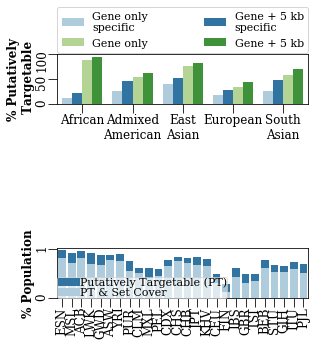

In [6]:
fig2 = plt.figure()
plt.rc("font", size=12)
plt.rcParams["font.family"] = "serif"
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1,1.8,1],
                      width_ratios=[1,1])
gs.update(wspace=0.0, hspace=0.41)

# 5kb = more targetability

fig2_ax1 = plt.subplot(gs[0,:])
colors = list(sns.color_palette("Dark2", n_colors=4))

rho_5kb = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

# rho_5kb.query('targ_all').shape[0]/2504.0

rho_5kb_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop[superpop] = rho_5kb.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop[superpop] = rho_gene_only.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_propdf = pd.DataFrame.from_dict(rho_5kb_prop, orient='index')
rho_5kb_propdf.columns=['prop_targ']
rho_5kb_propdf['superpop'] = rho_5kb_propdf.index
# rho_5kb_propdf = rho_5kb_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_5kb_propdf['id'] = '5kb'

rho_gene_only_propdf = pd.DataFrame.from_dict(rho_gene_only_prop, orient='index')
rho_gene_only_propdf.columns=['prop_targ']
rho_gene_only_propdf['superpop'] = rho_gene_only_propdf.index
# rho_gene_only_propdf = rho_gene_only_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_gene_only_propdf['id'] = 'gene_only'

rho_5kb_spec = pd.read_hdf('../testing/sgRNAs_1kgp/spcas9/rho5kb_ef_output/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only_spec = pd.read_hdf('../testing/sgRNAs_1kgp/spcas9/rho5_ef_output/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

rho_5kb_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop_spec[superpop] = rho_5kb_spec.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop_spec[superpop] = rho_gene_only_spec.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_prop_specdf = pd.DataFrame.from_dict(rho_5kb_prop_spec, orient='index')
rho_5kb_prop_specdf.columns=['prop_targ']
rho_5kb_prop_specdf['superpop'] = rho_5kb_prop_specdf.index
rho_5kb_prop_specdf['id'] = '5kb_spec'

rho_gene_only_spec_propdf = pd.DataFrame.from_dict(rho_gene_only_prop_spec, orient='index')
rho_gene_only_spec_propdf.columns=['prop_targ']
rho_gene_only_spec_propdf['superpop'] = rho_gene_only_spec_propdf.index
rho_gene_only_spec_propdf['id'] = 'gene_only_spec'

plot_df = pd.concat([rho_5kb_propdf, rho_gene_only_propdf,
                    rho_gene_only_spec_propdf, rho_5kb_prop_specdf]).sort_values(by='prop_targ').replace(replace).replace(superpop_mapping)
plot_df['perc_targ'] = plot_df['prop_targ'] * 100.0

# colors = list(sns.color_palette("Dark2", n_colors=4))
# fig, ax = plt.subplots(figsize=(24, 6))
p = sns.barplot('superpop','perc_targ',hue='id', palette='Paired', data=plot_df, ax=fig2_ax1, order=['African','Admixed\nAmerican',
                                                                                                     'East\nAsian','European','South\nAsian'])
plt.ylim(0,100)
# labels = textwrap.wrap(l) for l in plot_df['superpop'].drop_duplicates().tolist()
handles, labels = fig2_ax1.get_legend_handles_labels()
handles = [handles[0],handles[2],handles[1],handles[3]]
labels = [labels[0],labels[2],labels[1],labels[3]]
fig2_ax1.legend(handles, labels,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.0,
               columnspacing=0.1, fontsize=11,markerscale=0.001)
# plt.xlabel('Population')
plt.ylabel('% Putatively\n Targetable', fontweight='bold')
plt.xlabel('')
fig2_ax1.tick_params(size=9, pad=0)
fig2_ax1.yaxis.labelpad = 0
fig2_ax1.xaxis.labelpad = 0
plt.yticks(rotation=90)
# plt.setp(p.get_xticklabels(), rotation=45)

# colors = list(sns.color_palette("Dark2", n_colors=5))
sample_legend = sample_legend.query('sample in @all_samples')
targ_dat = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')

targ_pops = targ_dat.merge(sample_legend, how='left')

plot_dict = {}

for pop in list(set(sample_legend['pop'].tolist())):
    plot_dict[pop] = targ_pops.query('pop == @pop and targ_all').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df = pd.DataFrame.from_dict(plot_dict, orient='index')
plot_df['pop'] = plot_df.index
plot_df.columns=['perc_targ','pop']
plot_df = plot_df.merge(sample_legend, how='left')
plot_df = plot_df.sort_values(by='perc_targ')

ppl_cov_five = pd.read_csv('plotting_data/RHO_5kb_setcover__ppl_covered.txt', header=None,
                          names=['sample'])

ppl_cov_five = ppl_cov_five.merge(sample_legend)

plot_dict_cov = {}

for pop in list(set(plot_df['pop'].tolist())):
#     print(pop)
    plot_dict_cov[pop] = ppl_cov_five.query('pop == @pop').shape[0]/sample_legend.query('pop == @pop').shape[0]

plot_df_final = pd.DataFrame.from_dict(plot_dict_cov, orient='index')
plot_df_final['pop'] = plot_df_final.index
plot_df_final.columns=['perc_targ','pop']
plot_df_final = plot_df_final.merge(sample_legend, how='left')

plot_df['id'] = 'targ'
plot_df_final['id'] = 'cov'

dual = pd.concat([plot_df, plot_df_final])
# dual.to_csv('plotting_data/rho_5kb_plot_df.tsv', sep='\t', index=False)

order_vector = dual.sort_values(by='superpop')['pop'].drop_duplicates().tolist()

fig2_ax2 = plt.subplot(gs[2,:])
colors = list(sns.color_palette("Paired", n_colors=4))
p = sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "targ"'),
            label="Putatively Targetable (PT)", color=colors[1], order=order_vector)
sns.barplot(x="pop", y="perc_targ", data=dual.query('id == "cov"'),
            label="PT & Set Cover", color=colors[0], order=order_vector, ax=fig2_ax2)
plt.ylabel('% Population', fontweight='bold')
plt.xlabel('')
plt.setp(p.get_xticklabels(), rotation=90)
fig2_ax2.legend(frameon=True, ncol=1, loc='lower left',handletextpad=0.01,
                columnspacing=0.1, fontsize=11,markerscale=0.001,borderaxespad=0,
               labelspacing=0,borderpad=0.03,framealpha=0.6)
fig2_ax2.tick_params(size=9, pad=0.0)
fig2_ax2.yaxis.labelpad = 0
fig2_ax2.xaxis.labelpad = 0
plt.yticks(rotation=90)

fig2.set_size_inches(4.5,4.5)

plt.savefig('figures/figure2.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Supplementary Figure: not used, specificity plot with SaCas9

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


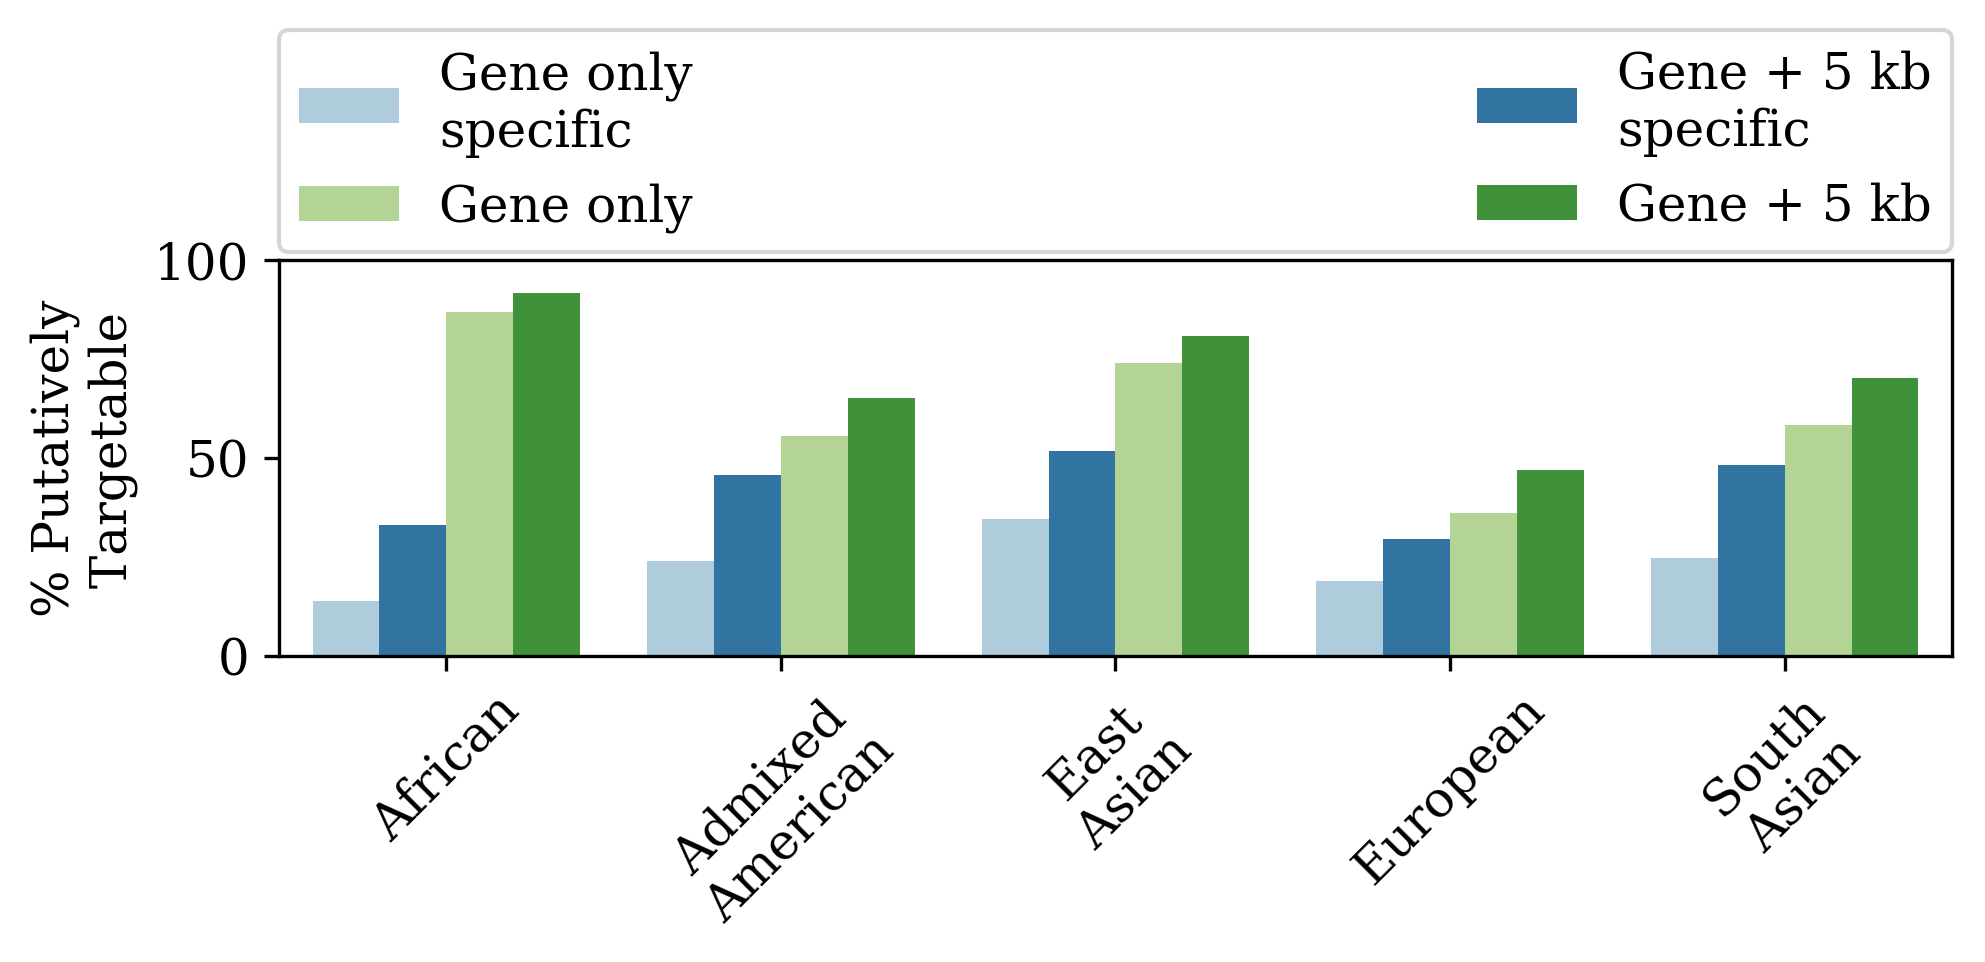

In [179]:
sample_legend = sample_legend.query('sample in @all_samples')

fig2 = plt.figure(figsize=(7.195,3.841), dpi=300)
plt.rc("font", size=12)
plt.rcParams["font.family"] = "serif"
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[1,1],
                      width_ratios=[1,1])

fig2_ax1 = plt.subplot(gs[0,:])
colors = list(sns.color_palette("Dark2", n_colors=4))

rho_5kb = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/chr3_out.hdf5', 
                            'RHO').merge(sample_legend, how='left')

# rho_5kb.query('targ_all').shape[0]/2504.0

rho_5kb_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop[superpop] = rho_5kb.query('sample in @samples and targ_SaCas9_KKH').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop[superpop] = rho_gene_only.query('sample in @samples and targ_SaCas9_KKH').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_propdf = pd.DataFrame.from_dict(rho_5kb_prop, orient='index')
rho_5kb_propdf.columns=['prop_targ']
rho_5kb_propdf['superpop'] = rho_5kb_propdf.index
# rho_5kb_propdf = rho_5kb_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_5kb_propdf['id'] = '5kb'

rho_gene_only_propdf = pd.DataFrame.from_dict(rho_gene_only_prop, orient='index')
rho_gene_only_propdf.columns=['prop_targ']
rho_gene_only_propdf['superpop'] = rho_gene_only_propdf.index
# rho_gene_only_propdf = rho_gene_only_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_gene_only_propdf['id'] = 'gene_only'

rho_5kb_spec = pd.read_hdf('../testing/sgRNAs_1kgp/rho5kb_ef_output_90_sacas9_v1/chr3_out.hdf5',
                           'RHO').merge(sample_legend, how='left')
rho_gene_only_spec = pd.read_hdf('../testing/sgRNAs_1kgp/rho_ef_output_90_sacas9_v1/chr3_out.hdf5', 
                                 'RHO').merge(sample_legend, how='left')

rho_5kb_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_5kb_prop_spec[superpop] = rho_5kb_spec.query('sample in @samples and targ_SaCas9_KKH').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_gene_only_prop_spec = {}
for superpop in sample_legend['superpop'].drop_duplicates().tolist():
    samples = sample_legend.query('superpop == @superpop')['sample'].tolist()
    rho_gene_only_prop_spec[superpop] = rho_gene_only_spec.query('sample in @samples and targ_SaCas9_KKH').shape[0]/sample_legend.query('superpop == @superpop and sample in @all_samples').shape[0]

rho_5kb_prop_specdf = pd.DataFrame.from_dict(rho_5kb_prop_spec, orient='index')
rho_5kb_prop_specdf.columns=['prop_targ']
rho_5kb_prop_specdf['superpop'] = rho_5kb_prop_specdf.index
rho_5kb_prop_specdf['id'] = '5kb_spec'

rho_gene_only_spec_propdf = pd.DataFrame.from_dict(rho_gene_only_prop_spec, orient='index')
rho_gene_only_spec_propdf.columns=['prop_targ']
rho_gene_only_spec_propdf['superpop'] = rho_gene_only_spec_propdf.index
rho_gene_only_spec_propdf['id'] = 'gene_only_spec'

plot_df = pd.concat([rho_5kb_propdf, rho_gene_only_propdf,
                    rho_gene_only_spec_propdf, rho_5kb_prop_specdf]).sort_values(by='prop_targ').replace(replace).replace(superpop_mapping)
plot_df['perc_targ'] = plot_df['prop_targ'] * 100.0

# colors = list(sns.color_palette("Dark2", n_colors=4))
# fig, ax = plt.subplots(figsize=(24, 6))
p = sns.barplot('superpop','perc_targ',hue='id', palette='Paired', data=plot_df, ax=fig2_ax1, order=['African','Admixed\nAmerican','East\nAsian','European','South\nAsian'])
plt.ylim(0,100)
handles, labels = fig2_ax1.get_legend_handles_labels()
handles = [handles[0],handles[2],handles[1],handles[3]]
labels = [labels[0],labels[2],labels[1],labels[3]]
plt.legend(handles, labels,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.xlabel('Population')
plt.ylabel('% Putatively\n Targetable')
# plt.title('SaCas9-V1')
plt.xlabel('')
plt.xticks(rotation=45)
# plt.savefig('figures/sacas9_v1_targ.pdf', format='pdf', bbox_inches='tight', dpi=300)

In [14]:
# import scores

scores = pd.read_csv('../testing/sgRNAs_1kgp/variant_scores_rho_5kb.tsv', sep='\t')
scores.columns = ['score','pos']

In [15]:
scores.head()

,score,pos
0,0,129257481
1,66,129245195
2,67,129251340
3,0,129243149
4,77,129255464


In [55]:
# import targ df for AF dat

targ_df = pd.read_hdf('/pollard/data/1kg/excisionFinderData/targ_dfs/chr3_targ.hdf5', where='pos >= 129242482 and pos <= 129259187')[['pos','id','af']]

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/all/_i_table/alt/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


In [56]:
targ_df.head()

,pos,id,af
3837558,129242501,rs9812975,0.048922
3837559,129242681,rs555765991,0.001797
3837560,129242683,rs189630341,0.000399
3837561,129242733,rs546956417,0.000200
3837562,129242779,rs72987920,0.003594


In [61]:
# import hap_targs

hap_targs = pd.read_hdf('plotting_data/RHO_5kb/hap_targ_ind_3.hdf5', 'RHO')

In [62]:
hap_targs = hap_targs.merge(sample_legend, how='left').query('hap1_SpCas9 or hap2_SpCas9')

In [63]:
hap_targs = hap_targs.merge(scores)
hap_targs.head()

,pos,sample,hap1_SpCas9,hap2_SpCas9,hap1_SpCas9_VRER,hap2_SpCas9_VRER,hap1_SpCas9_EQR,hap2_SpCas9_EQR,hap1_SpCas9_VQR_1,hap2_SpCas9_VQR_1,...,hap2_SaCas9_KKH,hap1_nmCas9,hap2_nmCas9,hap1_cjCas9,hap2_cjCas9,hap1_cpf1,hap2_cpf1,pop,superpop,score
0,129244318,HG00096,True,True,False,False,False,False,True,True,...,True,False,False,False,False,False,False,GBR,EUR,26
1,129244318,HG00099,True,True,False,False,False,False,True,True,...,True,False,False,False,False,False,False,GBR,EUR,26
2,129244318,HG00100,True,True,False,False,False,False,True,True,...,True,False,False,False,False,False,False,GBR,EUR,26
3,129244318,HG00107,True,True,False,False,False,False,True,True,...,True,False,False,False,False,False,False,GBR,EUR,26
4,129244318,HG00109,True,True,False,False,False,False,True,True,...,True,False,False,False,False,False,False,GBR,EUR,26


In [50]:
hap_targs.query('hap1_SpCas9 or hap2_SpCas9').groupby('superpop').mean()

,pos,hap1_SpCas9,hap2_SpCas9,hap1_SpCas9_VRER,hap2_SpCas9_VRER,hap1_SpCas9_EQR,hap2_SpCas9_EQR,hap1_SpCas9_VQR_1,hap2_SpCas9_VQR_1,hap1_SpCas9_VQR_2,...,hap2_SaCas9,hap1_SaCas9_KKH,hap2_SaCas9_KKH,hap1_nmCas9,hap2_nmCas9,hap1_cjCas9,hap2_cjCas9,hap1_cpf1,hap2_cpf1,score
superpop,,,,,,,,,,,,,,,,,,,,,
AFR,1.292516e+08,0.984159,0.984287,0.145120,0.145120,0.524016,0.524655,0.894098,0.897164,0.959121,...,0.667859,0.875703,0.876086,0.258559,0.256260,0.482115,0.478411,0.343383,0.340700,58.449540
AMR,1.292501e+08,0.998696,0.997066,0.181285,0.180633,0.616563,0.613629,0.953701,0.954679,0.974894,...,0.639713,0.887838,0.888490,0.426475,0.427127,0.463319,0.467884,0.276492,0.274209,56.961200
EAS,1.292498e+08,0.999492,0.999323,0.224103,0.224949,0.645565,0.641842,0.949898,0.950237,0.982058,...,0.606635,0.877793,0.877793,0.491706,0.491537,0.442112,0.442282,0.245261,0.242722,60.902336
EUR,1.292506e+08,0.996400,0.996760,0.188265,0.187185,0.564075,0.565515,0.943125,0.937365,0.948884,...,0.680706,0.910727,0.911447,0.372570,0.370050,0.460763,0.456803,0.263499,0.263139,55.012959
SAS,1.292505e+08,0.995529,0.995529,0.180754,0.177986,0.555248,0.554396,0.924846,0.926975,0.958058,...,0.696615,0.893123,0.893762,0.391527,0.393868,0.462423,0.463274,0.248882,0.245902,57.450075


In [64]:
hap_targs = hap_targs.merge(targ_df)
hap_targs = hap_targs[['pos','sample','pop','superpop','score','id','af']]
hap_targs.head()

,pos,sample,pop,superpop,score,id,af
0,129244318,HG00096,GBR,EUR,26,rs9823319,0.090056
1,129244318,HG00099,GBR,EUR,26,rs9823319,0.090056
2,129244318,HG00100,GBR,EUR,26,rs9823319,0.090056
3,129244318,HG00107,GBR,EUR,26,rs9823319,0.090056
4,129244318,HG00109,GBR,EUR,26,rs9823319,0.090056


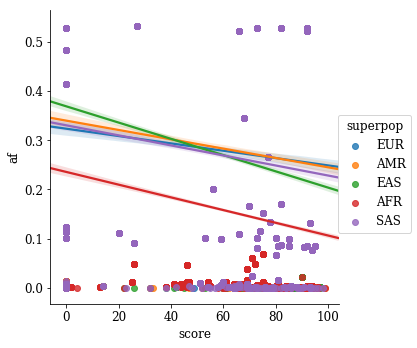

In [65]:
sns.lmplot(x='score', y='af',hue='superpop',
          data=hap_targs)

In [70]:
hap_targs.query('superpop == "AFR" and score >= 90')['sample'].drop_duplicates().shape

(350,)

In [71]:
hap_targs.query('superpop == "AFR" and score < 90')['sample'].drop_duplicates().shape

(622,)

In [74]:
high_score_inds = hap_targs.query('superpop == "AFR" and score >= 90')['sample'].tolist()

In [83]:
low_score_inds_df = hap_targs.query('superpop == "AFR" and sample not in @high_score_inds')

In [84]:
low_score_inds_df.head()

,pos,sample,pop,superpop,score,id,af
582,129252685,HG01890,ACB,AFR,0,rs11359208,0.482827
676,129252685,HG02256,ACB,AFR,0,rs11359208,0.482827
681,129252685,HG02283,ACB,AFR,0,rs11359208,0.482827
682,129252685,HG02284,ACB,AFR,0,rs11359208,0.482827
686,129252685,HG02317,ACB,AFR,0,rs11359208,0.482827


In [85]:
low_score_inds_df['id'].drop_duplicates().shape

(97,)

In [94]:
low_score_inds_df['af'].max()

0.527756

In [95]:
len(set(high_score_inds))

350

In [97]:
low_score_inds_df['sample'].drop_duplicates().shape

(272,)

In [102]:
hap_targs.query('superpop == "AFR"')['sample'].drop_duplicates().shape

(622,)

In [107]:
hap_targs.query('superpop == "SAS" and score==0')['pos'].drop_duplicates().shape

(22,)

# Supplementary Figure 1: Generation of allele-specific CRISPR sites by heterozgyous variants in WTC

Frequency of generation of allele-specific CRISPR sites at heterozygous variant for 11 Cas types in WTC differentiated by whether they are in a PAM or in the sgRNA recognition sequence.

/pollard/home/kathleen/tools/anaconda3/lib/python3.6/site-packages/tables/leaf.py:396: PerformanceWarning: The Leaf ``/all/_i_table/alt/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  PerformanceWarning)


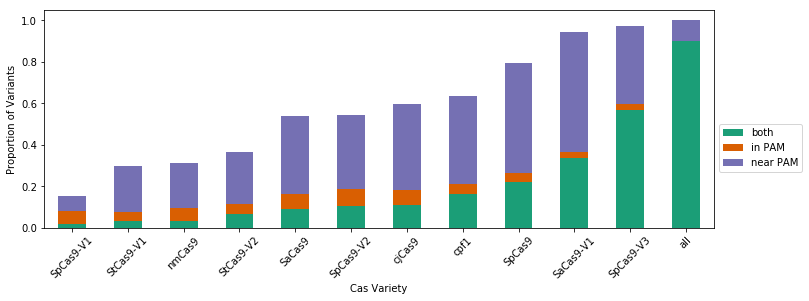

In [12]:
all_chr_df_list = []

for chrom in list(range(2,23)):
    chrom = str(chrom)
    chr_hdf = pd.read_hdf(f'/pollard/home/kathleen/projects/excisionFinder_old/example_analyses/biohub_26_genes/WTC_analysis_ef2/targ_dfs/chr{chrom}.hdf5', 'all').sample(1000)
    chr_hdf.head()
    all_chr_df_list.append(chr_hdf)

all_chr_df = pd.concat(all_chr_df_list)

all_chr_df = all_chr_df.drop(columns=['chrom','pos','ref','alt','id','af']).applymap(bool)
all_chr_df['id'] = all_chr_df.index

in_pam_dict = {}
near_pam_dict = {}

cas_list = ['cpf1','SpCas9','SpCas9_VRER','SpCas9_EQR','StCas9',
           'StCas9_2','SaCas9','SaCas9_KKH','nmCas9','cjCas9']
for cas in cas_list:
    in_pam_dict[cas] = all_chr_df.query(f'makes_{cas} or breaks_{cas}')['id'].tolist()
    near_pam_dict[cas] = all_chr_df.query(f'var_near_{cas}')['id'].tolist()
    
in_pam_dict['SpCas9_VQR'] = all_chr_df.query('makes_SpCas9_VQR_1 or breaks_SpCas9_VQR_1 \
                                              or makes_SpCas9_VQR_2 or breaks_SpCas9_VQR_2')['id'].tolist()
near_pam_dict['SpCas9_VQR'] = all_chr_df.query('var_near_SpCas9_VQR_1 \
                                              or var_near_SpCas9_VQR_2')['id'].tolist()
in_pam_dict['all'] = all_chr_df.query('makes_SpCas9_VQR_1 or breaks_SpCas9_VQR_1 \
                                      or makes_SpCas9_VQR_2 or breaks_SpCas9_VQR_2 \
                                      or makes_cpf1 or breaks_cpf1 or makes_SpCas9 or \
                                      breaks_SpCas9 or makes_SpCas9_VRER or breaks_SpCas9_VRER \
                                      or makes_SpCas9_EQR or breaks_SpCas9_EQR or \
                                      makes_StCas9 or breaks_StCas9 \
                                      or makes_SaCas9 or breaks_SaCas9 \
                                      or makes_SaCas9_KKH or breaks_SaCas9_KKH \
                                      or makes_nmCas9 or breaks_nmCas9 \
                                      or makes_cjCas9 or breaks_cjCas9')['id'].tolist()
near_pam_dict['all'] = all_chr_df.query('var_near_SpCas9_VQR_1 \
                                          or var_near_SpCas9_VQR_2  \
                                          or var_near_cpf1 or var_near_SpCas9 or \
                                          var_near_SpCas9_VRER  \
                                          or var_near_SpCas9_EQR or \
                                          var_near_StCas9 \
                                          or var_near_SaCas9 \
                                          or var_near_SaCas9_KKH\
                                          or var_near_nmCas9\
                                          or var_near_cjCas9')['id'].tolist()

total_vars = all_chr_df.shape[0]

labels = []
cases = []
perc_vars = []

inplot = []
nearplot = []
bothplot = []
cases2 = []
totals = []

for cas in cas_list + ['SpCas9_VQR','all']:
    near_pam = set(near_pam_dict[cas])
    in_pam = set(in_pam_dict[cas])
    both = near_pam.intersection(in_pam)
    nearpam = list(near_pam - both)
    inpam = list(in_pam - both)
#     total_vars = len(both) + len(nearpam) + len(inpam)
    near_out = len(nearpam) / total_vars
    in_out = len(inpam) / total_vars
    both_out = len(both) / total_vars
    perc_vars.extend([near_out, in_out, both_out])
    labels.extend(['near','in','both'])
    cases.extend([cas] * 3)
    inplot.extend([in_out])
    nearplot.extend([near_out])
    bothplot.extend([both_out])
    cases2.extend([cas])
    total = in_out + near_out + both_out
    totals.append(total)
    

plotdf = pd.DataFrame({'near PAM':nearplot, 'in PAM':inplot,'both':bothplot,'cas':cases2, 'total':totals}).replace(to_replace=cas_dict).sort_values(by='total')
plotdf.to_csv('fig1b_data.tsv', sep='\t')
plotdf.index = plotdf.cas

plotdf = plotdf[['both','in PAM','near PAM']]

plotdf.plot.bar(stacked='True', color=sns.color_palette('Dark2'), figsize=(12,4))
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Proportion of Variants')
plt.xlabel('Cas Variety')
# plt.savefig('figures/wtc_allelespecsites_by_variants.pdf', dpi=300, bbox_inches='tight')

Extra stuff that will get deleted if not needed by now. 

In [ ]:
%matplotlib inline

cas_dict = np.load('plotting_data/cas_abbrev_dict.npy').item()
sample_legend = pd.read_csv('plotting_data/sample_legend.tsv', sep='\t')
all_samples = np.load('plotting_data/all_samples.npy').tolist()
sample_legend.columns = ['sample','pop','superpop']

sample_legend = sample_legend.query('sample in @all_samples')
cas_dict['Cas9-V1'] = 'SpCas9-V1'
cas_dict['Cas9-V2'] = 'SpCas9-V2'
cas_dict['Cas9-V3'] = 'SpCas9-V3'
cas_dict['Cas9'] = 'SpCas9'

def get_canonical(gene_name, gene_annots, outdir=' '):
    """
    Get the canonical (longest) transcript of gene.
    :param gene_name: HUGO gene ID, str.
    :param gene_annots: refseq gene annotations, Pandas dataframe.
    :param outdir: directory to save files outputted by this program, str.
    :return: refseq transcript ID, str.
    """
    canonical_transcript = gene_annots.query('gene_name == @gene_name').name.iloc[0]
    return canonical_transcript


def het(genotype):
    """
    Determine whether a genotype in format A|G is het.
    :param genotype: genotype, str.
    :return: bool, True = het, False = hom.
    """
    hap1, hap2 = str(genotype).split('|')
    return hap1 != hap2


def load_gene_annots(annots_path):
    """
    Load gene annotation data (transcript data).
    :param annots_path: str, filepath for gene_annots_wsize (Part of ExcisionFinder package).
    :return: Refseq gene annotations file.
    """
    gene_annots = pd.read_csv(annots_path, sep='\t', header=0, names=['name', 'chrom', 'txStart', 'txEnd',
                                                                      'cdsStart', 'cdsEnd', 'exonCount',
                                                                      'exonStarts', 'exonEnds', 'gene_name',
                                                                      'size']).sort_values(by='size', ascending=False)
    return gene_annots

gene_annots = load_gene_annots('plotting_data/gene_annots_wsize')

In [ ]:
# overall = pd.read_csv('../wtc_ef/wtc_ef_plotting_data/wtc_single_dual_targeting.tsv', sep='\t')

# overall['size_kb'] = overall['size'] / 1000

# # Subset sizes
# s = (
#     overall.query('targ_type == "dual"').shape[0],  # Ab
#     overall.query('targ_type == "single"').shape[0],  # aB
#     overall.query('targ_type == "both"').shape[0])
# v = venn2(subsets=s, set_labels=['Dual Only','Single Only'])
# colors = list(sns.color_palette("Dark2", n_colors=4))
# v.get_patch_by_id('10').set_color(colors[0])
# v.get_patch_by_id('01').set_color(colors[2])term
# v.get_patch_by_id('11').set_color(colors[1])

# plt.savefig('figures/wtc_single_vs_dual_venn.pdf', dpi=300)

In [ ]:
rho_5kb = pd.read_hdf('plotting_data/RHO_5kb/chr3_out.hdf5','RHO').merge(sample_legend, how='left')
rho_gene_only = pd.read_hdf('/pollard/data/1kg/excisionFinderData/gene_targ_outputs/chr3/chr3_out.hdf5', 'RHO').merge(sample_legend, how='left')

# rho_5kb.query('targ_all').shape[0]/2504.0

rho_5kb_prop = {}
for pop in sample_legend['pop'].drop_duplicates().tolist():
    samples = sample_legend.query('pop == @pop')['sample'].tolist()
    rho_5kb_prop[pop] = rho_5kb.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('pop == @pop').shape[0]

rho_gene_only_prop = {}
for pop in sample_legend['pop'].drop_duplicates().tolist():
    samples = sample_legend.query('pop == @pop')['sample'].tolist()
    rho_gene_only_prop[pop] = rho_gene_only.query('sample in @samples and targ_SpCas9').shape[0]/sample_legend.query('pop == @pop').shape[0]

rho_5kb_propdf = pd.DataFrame.from_dict(rho_5kb_prop, orient='index')
rho_5kb_propdf.columns=['prop_targ']
rho_5kb_propdf['pop'] = rho_5kb_propdf.index
rho_5kb_propdf = rho_5kb_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_5kb_propdf['id'] = '5kb'

rho_gene_only_propdf = pd.DataFrame.from_dict(rho_gene_only_prop, orient='index')
rho_gene_only_propdf.columns=['prop_targ']
rho_gene_only_propdf['pop'] = rho_gene_only_propdf.index
rho_gene_only_propdf = rho_gene_only_propdf.merge(sample_legend[['pop','superpop']].drop_duplicates())
rho_gene_only_propdf['id'] = 'gene_only'

plot_df = pd.concat([rho_5kb_propdf, rho_gene_only_propdf]).sort_values(by='prop_targ')
plot_df['perc_targ'] = plot_df['prop_targ'] * 100.0

colors = list(sns.color_palette("Dark2", n_colors=4))
# fig, ax = plt.subplots(figsize=(24, 6))
p = sns.FacetGrid(plot_df,col='superpop', sharex=False, gridspec_kws={"width_ratios": [5, 4, 5, 5, 7]})
p.map(sns.barplot, 'pop', 'perc_targ','id',palette={'5kb':colors[2],'gene_only':colors[0]})
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# plt.setp(p.get_xticklabels(), rotation=45)
# plt.savefig('figures/rho_5kbwindow_vs_none.pdf', dpi=300, bbox_inches='tight')